<p style="align: center;"><img src="https://static.tildacdn.com/tild6636-3531-4239-b465-376364646465/Deep_Learning_School.png" width="400"></p>

# Глубокое обучение. Часть 2
# Домашнее задание по теме "Механизм внимания"

В этом задании вы будете решать задачу классификации математических задач по темам (многоклассовая классификация) с помощью Transformer.

В качестве датасета возьмем датасет математических задач по разным темам. Нам необходим следующий файл:

[Файл с классами](https://docs.google.com/spreadsheets/d/13YIbphbWc62sfa-bCh8MLQWKizaXbQK9/edit?usp=drive_link&ouid=104379615679964018037&rtpof=true&sd=true)

**Hint:** не перезаписывайте модели, которые вы получите на каждом из этапов этого дз. Они ещё понадобятся.

# Предобработка данных

In [ ]:
#!pip install openpyxl

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import warnings
warnings.filterwarnings("ignore")

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

### Загрузка данных

In [3]:
# xlsx файл содержащий датасет.
data_file = 'data_problems_translated.xlsx'
# Полный путь к датасету.
data_path = 'C:/Users/STEPANJUK/Desktop/Deep Learning - Natural Language Processing/lec_06_Finetuning/[homework]BART_Finetuning/' + data_file

# Создаём датафрейм датасета на базе xlsx файла.
data = pd.read_excel(data_path)
# Удалить пустой столбец датафрейма.
data = data.drop(columns='Unnamed: 0')

print(f'Количество строк: {data.shape[0]}, Количество столбцов: {data.shape[1]}')
data.head()

Количество строк: 5273, Количество столбцов: 2


,problem_text,topic
0,To prove that the sum of the numbers of the ex...,number_theory
1,( b) Will the statement of the previous challe...,number_theory
2,The quadratic three-member graph with the coef...,polynoms
3,Can you draw on the surface of Rubik's cube a ...,combinatorics
4,"Dima, who came from Vrunlandia, said that ther...",graphs


### Обзор данных

In [4]:
print(f'Количество уникальных topics: {data.topic.nunique()}')
print(f'Количество полных дубликатов: {data[data.duplicated()].shape[0]}')
print(f'Количество дубликатов по тексту: {sum(data["problem_text"].duplicated())}')
print(f'Количество пустых ячеек с текстом (NaN): {data["problem_text"].isna().sum()}')
data.topic.value_counts()

Количество уникальных topics: 7
Количество полных дубликатов: 29
Количество дубликатов по тексту: 954
Количество пустых ячеек с текстом (NaN): 5


topic
number_theory    2396
combinatorics    1020
dirichlet         441
polynoms          426
graphs            384
geometry          371
invariant         235
Name: count, dtype: int64

### Редактирование данных

In [5]:
# Удалим полные дубликаты
data = data.drop_duplicates().reset_index(drop=True)
print(f'Количество строк: {data.shape[0]}, Количество столбцов: {data.shape[1]}')

Количество строк: 5244, Количество столбцов: 2


In [6]:
# Удалим строки с пустыми ячейками с текстом (NaN)
data = data.dropna().reset_index(drop=True)
print(f'Количество пустых ячеек с текстом (NaN): {data["problem_text"].isna().sum()}')

Количество пустых ячеек с текстом (NaN): 0


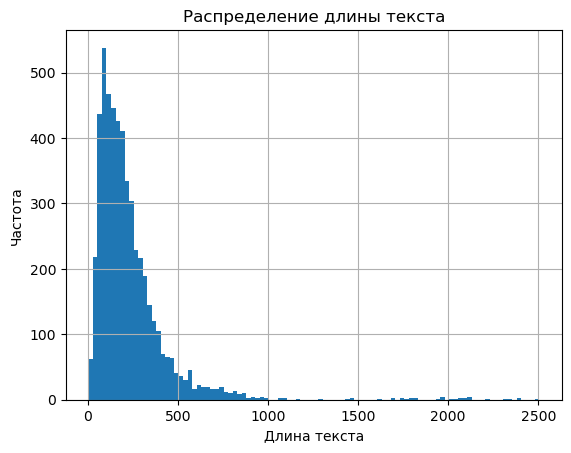

In [7]:
# Добавим столбец, который отображает длинну текста в каждой строчке.
data['length_text'] = data.problem_text.apply(lambda x: len(str(x)))

# Отобразим гистограмму показывающею распределение частоты встречаемости текстов разной длинны.
data.length_text.hist(bins=100)
plt.xlabel("Длина текста")  # Подпись оси X
plt.ylabel("Частота")       # Подпись оси Y
plt.title("Распределение длины текста")  # Заголовок графика
plt.grid(True)  # Добавляем сетку для удобства
plt.show()  # Показать график

In [8]:
# Посмотрим на распределение данных по длинне текста:
    # Кол-во текстов
    # Средняя длинна текста
    # Cтандартное отклонение 
    # Минимальная длинна текста
    # 25% (первый квартиль) – точка, ниже которой находится 25% данных.
    # 50% (медиана) – точка, ниже которой находится 50% данных (середина отсортированного массива).
    # 75% (третий квартиль) – точка, ниже которой находится 75% данных.
    # Максимальная длинна текста.
data.describe()

,length_text
count,5241.000000
mean,231.052280
std,215.735178
min,3.000000
25%,106.000000
50%,180.000000
75%,287.000000
max,2506.000000


#  Предобработка текста
- удалим последовательности, состоящие из одних цифр;
- приведем текст к нижнему регистру;
- удалим знаки пунктуации и стоп-слова из текстов;
- токенизируем тексты;
- нормализуем лексемы;
- объединим получившися строки, добавив в начале каждой последовательности токенов начальный символ [CLS] 

In [9]:
import pymorphy2
from pymorphy2 import MorphAnalyzer

import re
import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\STEPANJUK\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
# Список стоп-слов ("the", "is", "and", ...) для очистки текста – удаления бесполезных слов, которые не несут смысловой нагрузки.
ENG_STOP_WORDS = set(stopwords.words('english'))
# Токенизатор, который разбивает текст по словам и знакам пунктуации.
PUNCT_WORD_TOKENIZER = nltk.WordPunctTokenizer() 
# Создает морфологический анализатор, который помогает нормализовать слова (лемматизация (приведение к начальной форме)).
MORPH_ANALYZER = pymorphy2.MorphAnalyzer()

# Функция для предобработки текста
def preprocess_text(text):
    # text.lower() - Приводим text к нижнему регистру
    # re.sub() - заменим все числа ([0-9]+) на пустую строку (''), тем самым удаляя их.
    nums_filtered_text = re.sub(r'[0-9]+', '', text.lower())
    # Удалим всю пунктуацию.
    punct_filtered_text = ''.join([ch for ch in nums_filtered_text if ch not in string.punctuation])
    # Получим токены (список отдельных слов) из текста.
    tokens = PUNCT_WORD_TOKENIZER.tokenize(punct_filtered_text)
    # Уберём стоп-слова из списка и приведём токены (тдельные слова) к начальной форме.
    no_stopwords_filtered_tokens = [MORPH_ANALYZER.parse(token)[0].normal_form for token in tokens
                             if token not in ENG_STOP_WORDS]
    # Приведём токены (тдельные слова) к начальной форме.
    norm_tokens = [MORPH_ANALYZER.parse(token)[0].normal_form for token in no_stopwords_filtered_tokens]

    return f" {' '.join(norm_tokens)}"

In [11]:
preprocess_text('hello the WorlD 2025 !')

' hello world'

# Подготовка датасета

In [12]:
class MyDataset(Dataset):
    def __init__(self, dataframe=None, # Датафрейм с текстами и классами (темами) каждого текста.
                       max_length = 400, # Максимальная длинна текста.
                       tokenizer=None, # Токенизатор.
                       device = device):

        # Список предобработанных текстов.
        self.text = dataframe['problem_text'].apply(lambda x: preprocess_text(x)).tolist()
        # Список из классов (темам) для каждого текста.
        self.target = dataframe['topic'].tolist()
        # Максимальная длинна текста.
        self.max_length = max_length
        # Токенизатор.
        self.tokenizer = tokenizer
        self.device = device

    def __getitem__(self, idx):
        # Предобработанный текст.
        prep_text = self.text[idx]
        # Класс (тема) для текущего текста.
        target = self.target[idx]
    
        tokenized_text = self.tokenizer(text = prep_text, # Предварительно обработанный текст (например, очищенный от лишних символов или стоп-слов).
                                        padding = "max_length", # Дополнять все входные последовательности до максимальной длины, указанной в max_length.
                                        max_length = self.max_length, # Максимальная длина последовательности.
                                        #max_length = 2048, # Размер словаря токенов в токенизаторе.
                                        truncation = True, # Если текст слишком длинный, то его нужно обрезать до заданной максимальной длины.
                                        return_tensors = 'pt') # Результат должен быть возвращен в формате, совместимом с PyTorch.
          
        # Индексы токенов, полученные после токенизации текста.
        text_ids = tokenized_text['input_ids'].flatten()
        # Маска внимания, которая указывает модели, какие токены следует учитывать, а какие игнорировать.(padding-токен = 0, реальный токен = 1)
        attention_mask = tokenized_text['attention_mask'].flatten()
    
        return text_ids, attention_mask, torch.tensor(target, dtype=torch.long)

    def __len__(self):
        return len(self.text)

### Разделим данные на тренировочную и валидационную выборки

In [13]:
from sklearn.model_selection import train_test_split

# Словарь из класса(темы текста) в индекс.
label2ind = {topic:ind for ind,topic in enumerate(data.topic.unique())}
# Словарь индекса в класс(тему текста).
ind2label = {ind: topic for topic, ind in label2ind.items()}
# Кол-во классов.
NUM_CLASSES = len(label2ind)

# Преобразование значений в столбце topic (темы текстов) в соответствующие индексы.
data['topic'] = data['topic'].map(label2ind)

# Разделим данные на тренировочную и валидационную выборки
train_data, eval_data = train_test_split(data[['problem_text','topic']], stratify=data['topic'], test_size=0.15, random_state=42, shuffle=True)

### Задание 1 (2 балла)

Напишите кастомный класс для модели трансформера для задачи классификации, использующей в качествке backbone какую-то из моделей huggingface.

Т.е. конструктор класса должен принимать на вход название модели и подгружать её из huggingface, а затем использовать в качестве backbone (достаточно возможности использовать в качестве backbone те модели, которые упомянуты в последующих пунктах)

In [14]:
from typing import Union, List

class TransformerClassificationModel(nn.Module):
    def __init__(self, base_transformer_model: Union[str, nn.Module], num_classes: int):
        super().__init__()
        # Если 'base_transformer_model' является экземпляром 'str'.
        if isinstance(base_transformer_model, str):
            # config модели huggingface.
            self.config = AutoConfig.from_pretrained(base_transformer_model)
            # backbone модели huggingface.
            self.backbone = AutoModel.from_pretrained(base_transformer_model)
            
        # Если 'base_transformer_model' является экземпляром 'nn.Module'.
        elif isinstance(base_transformer_model, nn.Module):
            # backbone модели huggingface.
            self.backbone = base_transformer_model
            # config модели huggingface.
            self.config = self.backbone.config
        else:
            raise ValueError("`base_transformer_model` must be a string or a nn.Module instance.")

        self.dropout = nn.Dropout(0.1)
        # Предсказывающий линейный слой.
        self.classifier = nn.Linear(self.config.hidden_size, num_classes)
        

    def forward(self, inputs, output_attentions=True):
        # Содержат ли входные данные маску внимания, которая указывает модели, какие токены 
        # следует учитывать, а какие игнорировать.(padding-токен = 0, реальный токен = 1).
        if output_attentions:
            outputs = self.backbone(**inputs, output_attentions=True)
        else:
            outputs = self.backbone(**inputs)

        # Обобщенная информация обо всем тексте.
        pooled_output = outputs.last_hidden_state[:, 0, :]
        pooled_output = self.dropout(pooled_output)
        
        # Предсказание класса (темы) текста.
        logits = self.classifier(pooled_output)

        if output_attentions:
            return {"logits": logits, "attentions": outputs.attentions}
        else:
          return {"logits": logits}

### Задание 2 (1 балл)

Напишите функцию заморозки backbone у модели (если необходимо, возвращайте из функции модель)

In [15]:
def freeze_backbone_function(model: TransformerClassificationModel):
    for param in model.backbone.parameters():
      param.requires_grad = False
    return model

### Задание 3 (2 балла)

Напишите функцию, которая будет использована для тренировки (дообучения) трансформера (TransformerClassificationModel). Функция должна поддерживать обучение с замороженным и размороженным backbone.

In [16]:
import copy
import gc
from tqdm.auto import tqdm
from evaluate import load
acc_metric = load("accuracy")

def train_transformer(transformer_model, n_epochs, train_dataloader, eval_dataloader, freeze_backbone=True, device=device):
    # Создаём копию модели
    model = copy.deepcopy(transformer_model).to(device)
    # Функция потерь.
    criterion = nn.CrossEntropyLoss()
    # Оптимизатор
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

    # Список CrossEntropyLoss для всех эпох.
    history_loss = {'train':[], 'valid':[]}
    # Список метрики accuracy для всех эпох.
    history_acc = {'train':[], 'valid':[]}

    # Заморозить веса модели.
    if freeze_backbone:
        model = freeze_backbone_function(model)

    # Пройти по эпохам.
    for epoch_number in tqdm(range(n_epochs)):
        # Переводим модель в режим для обучения
        model.train()
        tr_loss = 0
        cnt_answers = 0
        cnt_right_answers = 0

        # Пройти по бачам тренировочного даталоадера.
        for data in tqdm(train_dataloader):
            # Обнулим производные.
            optimizer.zero_grad()

            # Передадим данные в устройство на котором будет производится расчёт.
            input_data, attention_mask, labels = data
            input_data, attention_mask, labels = input_data.to(device), attention_mask.to(device), labels.to(device).long()

            # Формируем вход для модели.
            inputs = {"input_ids": input_data, "attention_mask": attention_mask}

            # Посчитать логиты предсказаний для всех классов.
            outputs = model(inputs)
            pred = outputs['logits'].argmax(axis=-1)
            
            # Расчитать функцию потерь "CrossEntropyLoss"
            loss = criterion(outputs['logits'], labels)

            tr_loss += loss.item()
            # Кол-во ответов.
            cnt_answers += labels.shape[0]
            # Кол-во правильных ответов.
            cnt_right_answers += (pred == labels).sum().item()
            
            # Расчитать производные
            loss.backward()
            # Сделать шаг обучения
            optimizer.step()
            
        # Сохранить значения функции потерь "CrossEntropyLoss"  для текущей эпохи.
        history_loss['train'].append(tr_loss / len(train_dataloader))
        # Сохранить значения метрики accuracy для текущей эпохи.
        history_acc['train'].append(cnt_right_answers / cnt_answers)

        # Переводим модель в режим для оценки предсказаний
        model.eval()
        val_loss = 0
        vcnt_answers = 0
        vcnt_right_answers = 0

        # Без расчёта производных.
        with torch.no_grad():
            # Пройти через все батчи валидационого даталоадера.
            for vdata in tqdm(eval_dataloader):
                # Передадим данные в устройство на котором будет производится расчёт.
                input_data, attention_mask, labels = vdata
                input_data, attention_mask, labels = input_data.to(device), attention_mask.to(device), labels.to(device).long()

                # Формируем вход для модели.
                inputs = {"input_ids": input_data, "attention_mask": attention_mask}
                
                # Посчитать логиты предсказаний для всех классов.
                outputs = model(inputs)
                pred = outputs['logits'].argmax(axis=-1)
                
                # Расчитать функцию потерь "CrossEntropyLoss"
                vloss = criterion(outputs['logits'], labels)

                val_loss += vloss.item()
                # Кол-во ответов.
                vcnt_answers += labels.shape[0]
                # Кол-во правильных ответов.
                vcnt_right_answers += (pred == labels).sum().item()

            # Сохранить значения функции потерь "CrossEntropyLoss"  для текущей эпохи.
            history_loss['valid'].append(val_loss / len(eval_dataloader))
            # Сохранить значения метрики accuracy для текущей эпохи.
            history_acc['valid'].append(vcnt_right_answers / vcnt_answers)

            print('EPOCH {}:'.format(epoch_number + 1), "\n**TRAIN loss:", tr_loss / len(train_dataloader),
                  "**TRAIN Accuracy:", cnt_right_answers / cnt_answers,
                  "\n**EVAL loss:", val_loss / len(eval_dataloader),
                  "**EVAL Accuracy:", vcnt_right_answers / vcnt_answers,
                  '\n','-'*100
                 )
            del input_data, attention_mask, labels

        torch.cuda.empty_cache()
        gc.collect()

    return model, history_loss, history_acc

### Функция для отображения графика обучения.

In [17]:
def history_plot(history_loss, history_acc, name):
    print(f"Лучшая accuracy на валидации: {(max(history_acc['valid']) * 100):.2f}")
    fig, ax = plt.subplots(1,2, figsize=(15, 5))

    ax[0].plot(history_loss['train'], label="train_loss",color='lightblue')
    ax[0].plot(history_loss['valid'], label="val_loss",color='orange')
    ax[0].legend(['train', 'valid'])
    ax[0].set_xlabel('epochs')
    ax[0].set_ylabel("loss")
    plt.grid()

    ax[1].plot(history_acc['train'], label="train_acc",color='lightblue')
    ax[1].plot(history_acc['valid'], label="val_acc",color='orange')
    ax[1].legend(['train', 'valid'])
    ax[1].set_xlabel('epochs')
    ax[1].set_ylabel("accuracy")
    plt.grid()

    fig.suptitle(f'History of "{name}" model')
    plt.show()

MEAN_ACC_MODELS_HISTORY = {}

### Задание 4 (1 балл)

Проверьте вашу функцию из предыдущего пункта, дообучив двумя способами
*cointegrated/rubert-tiny2* из huggingface.

### Создадим даталоадеры

In [18]:
import transformers
from transformers import BertModel, AutoModel, AutoConfig, AutoTokenizer

# Имя предобученой модели, которая будет взята за основу.
MODEL_NAME = 'cointegrated/rubert-tiny2'
MODEL_NAME_frz = MODEL_NAME +'_frz'

# Токенизатор из предобученой модели.
tokenizer_rt = AutoTokenizer.from_pretrained(MODEL_NAME)

# Тренировочнуый и валидационный датасеты.
train_dataset = MyDataset(dataframe=train_data, tokenizer=tokenizer_rt)
eval_dataset = MyDataset(dataframe=eval_data, tokenizer=tokenizer_rt)

# Тренировочнуый и валидационный даталоадеры.
train_loader_rt = DataLoader(train_dataset, batch_size=16, shuffle=True)
eval_loader_rt = DataLoader(eval_dataset, batch_size=8, shuffle=True)

### Создадим экземпляр модели   *'cointegrated/rubert-tiny2'*

In [19]:
# Предобученая модель 'cointegrated/rubert-tiny2'.
pretrained_model_rt = BertModel.from_pretrained(MODEL_NAME, output_attentions=True)
# Кастомная модель на базе 'cointegrated/rubert-tiny2'.
model_rt = TransformerClassificationModel(pretrained_model_rt, NUM_CLASSES).to(device)

### Обучение кастомной модели на базе 'cointegrated/rubert-tiny2'

In [20]:
# Обучение кастомной модели на базе 'cointegrated/rubert-tiny2'.
rubert_tiny_unfrz, rt_history_loss_unfrz, rt_history_acc_unfrz = train_transformer(transformer_model=model_rt
                                                                                   ,n_epochs=25
                                                                                   ,train_dataloader=train_loader_rt
                                                                                   ,eval_dataloader=eval_loader_rt
                                                                                   ,freeze_backbone=False
                                                                                   ,device=device)

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/279 [00:00<?, ?it/s]

BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


  0%|          | 0/99 [00:00<?, ?it/s]

EPOCH 1: 
**TRAIN loss: 1.5005432318188383 **TRAIN Accuracy: 0.460035922766053 
**EVAL loss: 1.2924956607096123 **EVAL Accuracy: 0.5324015247776366 
 ----------------------------------------------------------------------------------------------------


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

EPOCH 2: 
**TRAIN loss: 1.2140834045239246 **TRAIN Accuracy: 0.5565783565334531 
**EVAL loss: 1.1437882886390494 **EVAL Accuracy: 0.5705209656925032 
 ----------------------------------------------------------------------------------------------------


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

EPOCH 3: 
**TRAIN loss: 1.1070697074722646 **TRAIN Accuracy: 0.5871127076784912 
**EVAL loss: 1.0881367133121298 **EVAL Accuracy: 0.590851334180432 
 ----------------------------------------------------------------------------------------------------


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

EPOCH 4: 
**TRAIN loss: 1.0355937500153818 **TRAIN Accuracy: 0.6091154018859453 
**EVAL loss: 1.0510139350939278 **EVAL Accuracy: 0.5895806861499364 
 ----------------------------------------------------------------------------------------------------


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

EPOCH 5: 
**TRAIN loss: 0.9775340771803291 **TRAIN Accuracy: 0.6297709923664122 
**EVAL loss: 1.0443544384807046 **EVAL Accuracy: 0.5921219822109276 
 ----------------------------------------------------------------------------------------------------


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

EPOCH 6: 
**TRAIN loss: 0.93236293480815 **TRAIN Accuracy: 0.6484059272563988 
**EVAL loss: 1.027319970155003 **EVAL Accuracy: 0.6035578144853876 
 ----------------------------------------------------------------------------------------------------


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

EPOCH 7: 
**TRAIN loss: 0.9027714320194764 **TRAIN Accuracy: 0.6544678940278401 
**EVAL loss: 1.0228569817663444 **EVAL Accuracy: 0.5997458703939009 
 ----------------------------------------------------------------------------------------------------


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

EPOCH 8: 
**TRAIN loss: 0.863621692717289 **TRAIN Accuracy: 0.6706331387516838 
**EVAL loss: 1.0249651826993385 **EVAL Accuracy: 0.5984752223634053 
 ----------------------------------------------------------------------------------------------------


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

EPOCH 9: 
**TRAIN loss: 0.8335367545859361 **TRAIN Accuracy: 0.6834306241580602 
**EVAL loss: 1.034132244912061 **EVAL Accuracy: 0.6086404066073697 
 ----------------------------------------------------------------------------------------------------


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

EPOCH 10: 
**TRAIN loss: 0.8039948464935398 **TRAIN Accuracy: 0.6892680736416704 
**EVAL loss: 1.0307937147039357 **EVAL Accuracy: 0.6060991105463787 
 ----------------------------------------------------------------------------------------------------


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

EPOCH 11: 
**TRAIN loss: 0.7806871526450666 **TRAIN Accuracy: 0.6971261787157611 
**EVAL loss: 1.0388014811759043 **EVAL Accuracy: 0.5870393900889453 
 ----------------------------------------------------------------------------------------------------


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

EPOCH 12: 
**TRAIN loss: 0.7526117648702368 **TRAIN Accuracy: 0.7088010776829816 
**EVAL loss: 1.0383126449705375 **EVAL Accuracy: 0.5997458703939009 
 ----------------------------------------------------------------------------------------------------


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

EPOCH 13: 
**TRAIN loss: 0.7332604981451479 **TRAIN Accuracy: 0.7153120790300853 
**EVAL loss: 1.064538033472167 **EVAL Accuracy: 0.5921219822109276 
 ----------------------------------------------------------------------------------------------------


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

EPOCH 14: 
**TRAIN loss: 0.7094242104385916 **TRAIN Accuracy: 0.7269869779973058 
**EVAL loss: 1.0716888922633547 **EVAL Accuracy: 0.5844980940279543 
 ----------------------------------------------------------------------------------------------------


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

EPOCH 15: 
**TRAIN loss: 0.6878041118703863 **TRAIN Accuracy: 0.7308037718904355 
**EVAL loss: 1.0728353596094884 **EVAL Accuracy: 0.5895806861499364 
 ----------------------------------------------------------------------------------------------------


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

EPOCH 16: 
**TRAIN loss: 0.6591522432463144 **TRAIN Accuracy: 0.7343960484957341 
**EVAL loss: 1.0964813876633692 **EVAL Accuracy: 0.5857687420584498 
 ----------------------------------------------------------------------------------------------------


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

EPOCH 17: 
**TRAIN loss: 0.6429293502829836 **TRAIN Accuracy: 0.7487651549169286 
**EVAL loss: 1.105803867181142 **EVAL Accuracy: 0.579415501905972 
 ----------------------------------------------------------------------------------------------------


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

EPOCH 18: 
**TRAIN loss: 0.6246745543133828 **TRAIN Accuracy: 0.7568477772788504 
**EVAL loss: 1.1238552672092361 **EVAL Accuracy: 0.5743329097839899 
 ----------------------------------------------------------------------------------------------------


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

EPOCH 19: 
**TRAIN loss: 0.6038510115236364 **TRAIN Accuracy: 0.7599910193084868 
**EVAL loss: 1.1404613163134065 **EVAL Accuracy: 0.5743329097839899 
 ----------------------------------------------------------------------------------------------------


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

EPOCH 20: 
**TRAIN loss: 0.5838820706772548 **TRAIN Accuracy: 0.7700942972608891 
**EVAL loss: 1.1690421894644245 **EVAL Accuracy: 0.5781448538754765 
 ----------------------------------------------------------------------------------------------------


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

EPOCH 21: 
**TRAIN loss: 0.57116194950637 **TRAIN Accuracy: 0.7696452626852268 
**EVAL loss: 1.1817256292008391 **EVAL Accuracy: 0.5692503176620076 
 ----------------------------------------------------------------------------------------------------


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

EPOCH 22: 
**TRAIN loss: 0.5560396609020062 **TRAIN Accuracy: 0.7721149528513696 
**EVAL loss: 1.1981539486935644 **EVAL Accuracy: 0.567979669631512 
 ----------------------------------------------------------------------------------------------------


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

EPOCH 23: 
**TRAIN loss: 0.535087642810678 **TRAIN Accuracy: 0.7822182308037718 
**EVAL loss: 1.2201161989659974 **EVAL Accuracy: 0.5667090216010165 
 ----------------------------------------------------------------------------------------------------


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

EPOCH 24: 
**TRAIN loss: 0.5348761401616544 **TRAIN Accuracy: 0.7804220925011226 
**EVAL loss: 1.2264670305179828 **EVAL Accuracy: 0.565438373570521 
 ----------------------------------------------------------------------------------------------------


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

EPOCH 25: 
**TRAIN loss: 0.5093844403716399 **TRAIN Accuracy: 0.7916479568926807 
**EVAL loss: 1.2796977755397256 **EVAL Accuracy: 0.5565438373570522 
 ----------------------------------------------------------------------------------------------------


Лучшая accuracy на валидации: 60.86


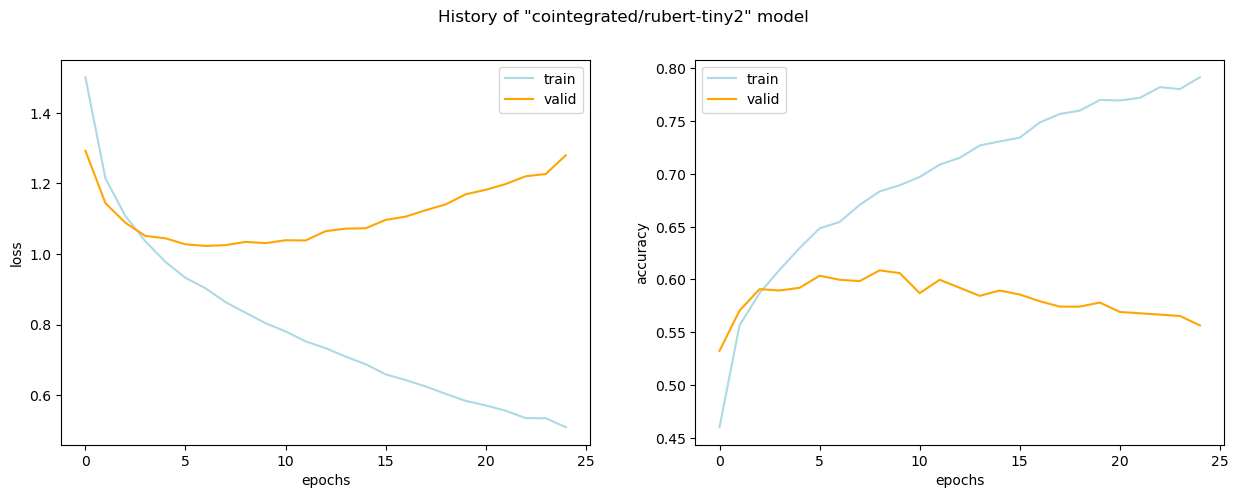

In [21]:
history_plot(rt_history_loss_unfrz, rt_history_acc_unfrz, MODEL_NAME)
MEAN_ACC_MODELS_HISTORY['accuracy'+MODEL_NAME] = np.mean(rt_history_acc_unfrz['valid'])

### Обучение кастомной модели на базе 'cointegrated/rubert-tiny2' с замороженными весами

In [22]:
# Обучение кастомной модели на базе 'cointegrated/rubert-tiny2' с замороженными весами.
rubert_tiny_frz, rt_history_loss_frz, rt_history_acc_frz = train_transformer(transformer_model=model_rt
                                                                             ,n_epochs=50
                                                                             ,train_dataloader=train_loader_rt
                                                                             ,eval_dataloader=eval_loader_rt
                                                                             ,freeze_backbone=True
                                                                             ,device=device)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

EPOCH 1: 
**TRAIN loss: 1.9136944355503205 **TRAIN Accuracy: 0.1881454872025146 
**EVAL loss: 1.853907043283636 **EVAL Accuracy: 0.31639135959339265 
 ----------------------------------------------------------------------------------------------------


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

EPOCH 2: 
**TRAIN loss: 1.8006544014886288 **TRAIN Accuracy: 0.37943421643466546 
**EVAL loss: 1.7552861854283497 **EVAL Accuracy: 0.4383735705209657 
 ----------------------------------------------------------------------------------------------------


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

EPOCH 3: 
**TRAIN loss: 1.7213840018891091 **TRAIN Accuracy: 0.4418500224517288 
**EVAL loss: 1.6906182284306999 **EVAL Accuracy: 0.4599745870393901 
 ----------------------------------------------------------------------------------------------------


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

EPOCH 4: 
**TRAIN loss: 1.6648927811653382 **TRAIN Accuracy: 0.4557700942972609 
**EVAL loss: 1.6376941505104605 **EVAL Accuracy: 0.4650571791613723 
 ----------------------------------------------------------------------------------------------------


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

EPOCH 5: 
**TRAIN loss: 1.6267942907989665 **TRAIN Accuracy: 0.4562191288729232 
**EVAL loss: 1.6011001582097526 **EVAL Accuracy: 0.46378653113087676 
 ----------------------------------------------------------------------------------------------------


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

EPOCH 6: 
**TRAIN loss: 1.5974640051523845 **TRAIN Accuracy: 0.460035922766053 
**EVAL loss: 1.57707560784889 **EVAL Accuracy: 0.46378653113087676 
 ----------------------------------------------------------------------------------------------------


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

EPOCH 7: 
**TRAIN loss: 1.5716958631324085 **TRAIN Accuracy: 0.457341715312079 
**EVAL loss: 1.5552628016231036 **EVAL Accuracy: 0.46124523506988563 
 ----------------------------------------------------------------------------------------------------


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

EPOCH 8: 
**TRAIN loss: 1.5536634332390242 **TRAIN Accuracy: 0.4598114054782218 
**EVAL loss: 1.5384203677225594 **EVAL Accuracy: 0.4625158831003812 
 ----------------------------------------------------------------------------------------------------


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

EPOCH 9: 
**TRAIN loss: 1.5355881589287925 **TRAIN Accuracy: 0.4564436461607544 
**EVAL loss: 1.5184871403857916 **EVAL Accuracy: 0.4625158831003812 
 ----------------------------------------------------------------------------------------------------


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

EPOCH 10: 
**TRAIN loss: 1.5244919702570925 **TRAIN Accuracy: 0.4595868881903907 
**EVAL loss: 1.5123530114539947 **EVAL Accuracy: 0.4599745870393901 
 ----------------------------------------------------------------------------------------------------


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

EPOCH 11: 
**TRAIN loss: 1.514285216408391 **TRAIN Accuracy: 0.4582397844634037 
**EVAL loss: 1.4949927926063538 **EVAL Accuracy: 0.4599745870393901 
 ----------------------------------------------------------------------------------------------------


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

EPOCH 12: 
**TRAIN loss: 1.4996436148561456 **TRAIN Accuracy: 0.4593623709025595 
**EVAL loss: 1.4840025191355233 **EVAL Accuracy: 0.46124523506988563 
 ----------------------------------------------------------------------------------------------------


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

EPOCH 13: 
**TRAIN loss: 1.4907473223183745 **TRAIN Accuracy: 0.4598114054782218 
**EVAL loss: 1.4714546877928454 **EVAL Accuracy: 0.4599745870393901 
 ----------------------------------------------------------------------------------------------------


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

EPOCH 14: 
**TRAIN loss: 1.4800540349816764 **TRAIN Accuracy: 0.4607094746295465 
**EVAL loss: 1.4622651097750423 **EVAL Accuracy: 0.4599745870393901 
 ----------------------------------------------------------------------------------------------------


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

EPOCH 15: 
**TRAIN loss: 1.4708933146623728 **TRAIN Accuracy: 0.46138302649303997 
**EVAL loss: 1.4567278021513814 **EVAL Accuracy: 0.45870393900889456 
 ----------------------------------------------------------------------------------------------------


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

EPOCH 16: 
**TRAIN loss: 1.460968963134246 **TRAIN Accuracy: 0.4622810956443646 
**EVAL loss: 1.4515164458390437 **EVAL Accuracy: 0.45743329097839897 
 ----------------------------------------------------------------------------------------------------


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

EPOCH 17: 
**TRAIN loss: 1.451948968740347 **TRAIN Accuracy: 0.46497530309833857 
**EVAL loss: 1.43922301494714 **EVAL Accuracy: 0.46378653113087676 
 ----------------------------------------------------------------------------------------------------


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

EPOCH 18: 
**TRAIN loss: 1.4403695630770859 **TRAIN Accuracy: 0.46564885496183206 
**EVAL loss: 1.4269141657183868 **EVAL Accuracy: 0.4625158831003812 
 ----------------------------------------------------------------------------------------------------


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

EPOCH 19: 
**TRAIN loss: 1.4339592358544735 **TRAIN Accuracy: 0.46699595868881905 
**EVAL loss: 1.4243999912281229 **EVAL Accuracy: 0.4663278271918678 
 ----------------------------------------------------------------------------------------------------


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

EPOCH 20: 
**TRAIN loss: 1.4269401245219733 **TRAIN Accuracy: 0.46699595868881905 
**EVAL loss: 1.4079862236976624 **EVAL Accuracy: 0.4663278271918678 
 ----------------------------------------------------------------------------------------------------


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

EPOCH 21: 
**TRAIN loss: 1.414887747029677 **TRAIN Accuracy: 0.4755276156264032 
**EVAL loss: 1.4045147775399565 **EVAL Accuracy: 0.46886912325285895 
 ----------------------------------------------------------------------------------------------------


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

EPOCH 22: 
**TRAIN loss: 1.4115518192663843 **TRAIN Accuracy: 0.46677144140098786 
**EVAL loss: 1.3896058298120595 **EVAL Accuracy: 0.4714104193138501 
 ----------------------------------------------------------------------------------------------------


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

EPOCH 23: 
**TRAIN loss: 1.3999152762488225 **TRAIN Accuracy: 0.4753030983385721 
**EVAL loss: 1.389330090898456 **EVAL Accuracy: 0.47395171537484115 
 ----------------------------------------------------------------------------------------------------


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

EPOCH 24: 
**TRAIN loss: 1.3950510804798442 **TRAIN Accuracy: 0.4768747193533902 
**EVAL loss: 1.3792329719572356 **EVAL Accuracy: 0.47903430749682335 
 ----------------------------------------------------------------------------------------------------


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

EPOCH 25: 
**TRAIN loss: 1.3885779479071232 **TRAIN Accuracy: 0.4824876515491693 
**EVAL loss: 1.370860629611545 **EVAL Accuracy: 0.48284625158831 
 ----------------------------------------------------------------------------------------------------


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

EPOCH 26: 
**TRAIN loss: 1.3787851677573282 **TRAIN Accuracy: 0.48810058374494836 
**EVAL loss: 1.359968653230956 **EVAL Accuracy: 0.48538754764930114 
 ----------------------------------------------------------------------------------------------------


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

EPOCH 27: 
**TRAIN loss: 1.3743953621515663 **TRAIN Accuracy: 0.49124382577458464 
**EVAL loss: 1.362135269425132 **EVAL Accuracy: 0.5031766200762389 
 ----------------------------------------------------------------------------------------------------


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

EPOCH 28: 
**TRAIN loss: 1.367200656817378 **TRAIN Accuracy: 0.4950606196677144 
**EVAL loss: 1.3498467243078984 **EVAL Accuracy: 0.5069885641677255 
 ----------------------------------------------------------------------------------------------------


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

EPOCH 29: 
**TRAIN loss: 1.3643521147389566 **TRAIN Accuracy: 0.4993264481365065 
**EVAL loss: 1.3468625166199424 **EVAL Accuracy: 0.5057179161372299 
 ----------------------------------------------------------------------------------------------------


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

EPOCH 30: 
**TRAIN loss: 1.358986449711639 **TRAIN Accuracy: 0.4982038616973507 
**EVAL loss: 1.3425353735384316 **EVAL Accuracy: 0.5120711562897078 
 ----------------------------------------------------------------------------------------------------


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

EPOCH 31: 
**TRAIN loss: 1.3540578621262718 **TRAIN Accuracy: 0.5008980691513246 
**EVAL loss: 1.3354462818665938 **EVAL Accuracy: 0.5133418043202033 
 ----------------------------------------------------------------------------------------------------


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

EPOCH 32: 
**TRAIN loss: 1.3455904047121712 **TRAIN Accuracy: 0.5116748989672205 
**EVAL loss: 1.331298665566878 **EVAL Accuracy: 0.5184243964421855 
 ----------------------------------------------------------------------------------------------------


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

EPOCH 33: 
**TRAIN loss: 1.3403873781149533 **TRAIN Accuracy: 0.5107768298158958 
**EVAL loss: 1.3230368368553393 **EVAL Accuracy: 0.5222363405336722 
 ----------------------------------------------------------------------------------------------------


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

EPOCH 34: 
**TRAIN loss: 1.3374716022108617 **TRAIN Accuracy: 0.5067355186349349 
**EVAL loss: 1.3181101908587447 **EVAL Accuracy: 0.5184243964421855 
 ----------------------------------------------------------------------------------------------------


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

EPOCH 35: 
**TRAIN loss: 1.3325290652158868 **TRAIN Accuracy: 0.5071845532105972 
**EVAL loss: 1.3165843565054614 **EVAL Accuracy: 0.5184243964421855 
 ----------------------------------------------------------------------------------------------------


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

EPOCH 36: 
**TRAIN loss: 1.3280338027571263 **TRAIN Accuracy: 0.5139200718455321 
**EVAL loss: 1.313956865758607 **EVAL Accuracy: 0.5235069885641678 
 ----------------------------------------------------------------------------------------------------


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

EPOCH 37: 
**TRAIN loss: 1.3206337846308198 **TRAIN Accuracy: 0.5217781769196228 
**EVAL loss: 1.306639136690082 **EVAL Accuracy: 0.5247776365946633 
 ----------------------------------------------------------------------------------------------------


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

EPOCH 38: 
**TRAIN loss: 1.3170818425848492 **TRAIN Accuracy: 0.5161652447238437 
**EVAL loss: 1.295259727673097 **EVAL Accuracy: 0.5285895806861499 
 ----------------------------------------------------------------------------------------------------


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

EPOCH 39: 
**TRAIN loss: 1.3133553450252848 **TRAIN Accuracy: 0.5181859003143242 
**EVAL loss: 1.2996488514572684 **EVAL Accuracy: 0.5298602287166455 
 ----------------------------------------------------------------------------------------------------


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

EPOCH 40: 
**TRAIN loss: 1.3020281325958962 **TRAIN Accuracy: 0.5251459362370903 
**EVAL loss: 1.2930690688316269 **EVAL Accuracy: 0.5324015247776366 
 ----------------------------------------------------------------------------------------------------


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

EPOCH 41: 
**TRAIN loss: 1.303609039407477 **TRAIN Accuracy: 0.5215536596317917 
**EVAL loss: 1.2923229884619665 **EVAL Accuracy: 0.5349428208386277 
 ----------------------------------------------------------------------------------------------------


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

EPOCH 42: 
**TRAIN loss: 1.3006930943031036 **TRAIN Accuracy: 0.5260440053884149 
**EVAL loss: 1.2873202718869605 **EVAL Accuracy: 0.5349428208386277 
 ----------------------------------------------------------------------------------------------------


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

EPOCH 43: 
**TRAIN loss: 1.2902657141822214 **TRAIN Accuracy: 0.5332285585990121 
**EVAL loss: 1.2808690468470256 **EVAL Accuracy: 0.5374841168996188 
 ----------------------------------------------------------------------------------------------------


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

EPOCH 44: 
**TRAIN loss: 1.2914470906325992 **TRAIN Accuracy: 0.5264930399640773 
**EVAL loss: 1.273975675154214 **EVAL Accuracy: 0.5412960609911055 
 ----------------------------------------------------------------------------------------------------


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

EPOCH 45: 
**TRAIN loss: 1.293629317514358 **TRAIN Accuracy: 0.5258194881005838 
**EVAL loss: 1.27085477896411 **EVAL Accuracy: 0.5400254129606099 
 ----------------------------------------------------------------------------------------------------


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

EPOCH 46: 
**TRAIN loss: 1.2840030765875265 **TRAIN Accuracy: 0.5325550067355186 
**EVAL loss: 1.2667758675536724 **EVAL Accuracy: 0.5412960609911055 
 ----------------------------------------------------------------------------------------------------


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

EPOCH 47: 
**TRAIN loss: 1.2811667844386083 **TRAIN Accuracy: 0.527615626403233 
**EVAL loss: 1.2637196309638745 **EVAL Accuracy: 0.542566709021601 
 ----------------------------------------------------------------------------------------------------


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

EPOCH 48: 
**TRAIN loss: 1.277250053848417 **TRAIN Accuracy: 0.5287382128423889 
**EVAL loss: 1.2654433744122284 **EVAL Accuracy: 0.5400254129606099 
 ----------------------------------------------------------------------------------------------------


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

EPOCH 49: 
**TRAIN loss: 1.2728461653100975 **TRAIN Accuracy: 0.5336775931746744 
**EVAL loss: 1.2549335246134286 **EVAL Accuracy: 0.5387547649301143 
 ----------------------------------------------------------------------------------------------------


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

EPOCH 50: 
**TRAIN loss: 1.2697568965214554 **TRAIN Accuracy: 0.5381679389312977 
**EVAL loss: 1.2574872151769774 **EVAL Accuracy: 0.5387547649301143 
 ----------------------------------------------------------------------------------------------------


Лучшая accuracy на валидации: 54.26


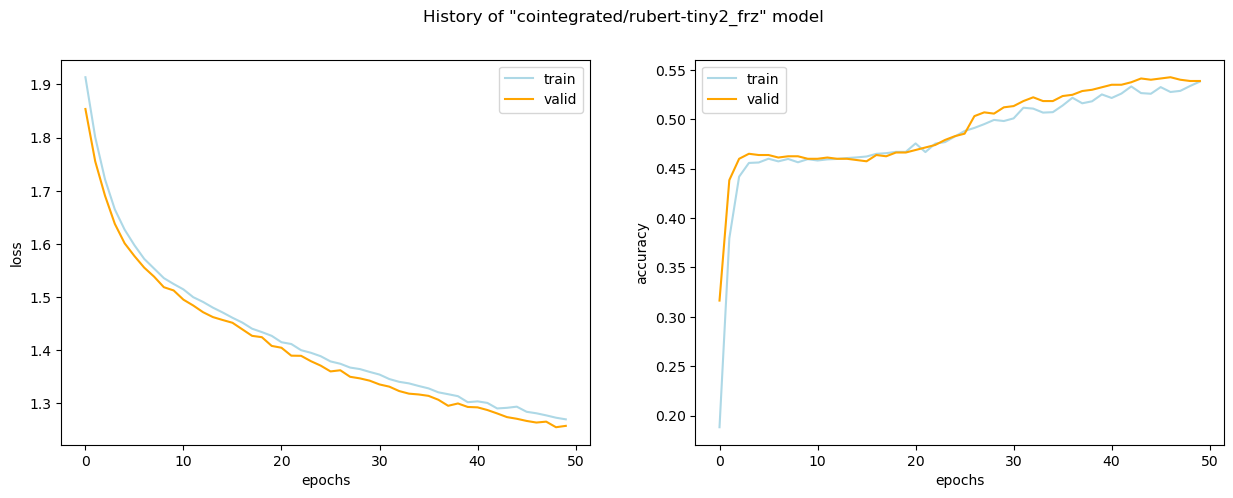

In [23]:
history_plot(rt_history_loss_frz, rt_history_acc_frz, MODEL_NAME_frz)
MEAN_ACC_MODELS_HISTORY['accuracy'+MODEL_NAME_frz] = np.mean(rt_history_acc_frz['valid'])

### Задание 5 (1 балл)

Обучите *tbs17/MathBert* (с замороженным backbone и без заморозки), проанализируйте результаты. Сравните скоры с первым заданием. Получилось лучше или нет? Почему?

**1) Обе модели без заморозки backbone довольно быстро переобучаться.**

**2) 'cointegrated/rubert-tiny2' обучается быстрей и лучше, чем 'tbs17/MathBert'.**

### Пересоздадим даталоадеры

In [24]:
# Имя предобученой модели, которая будет взята за основу.
MODEL_NAME = 'tbs17/MathBert'
MODEL_NAME_frz = MODEL_NAME +'_frz'

# Токенизатор из предобученой модели.
tokenizer_mb = AutoTokenizer.from_pretrained(MODEL_NAME)

# Тренировочнуый и валидационный датасеты.
train_dataset = MyDataset(dataframe=train_data, tokenizer=tokenizer_mb)
eval_dataset = MyDataset(dataframe=eval_data, tokenizer=tokenizer_mb)

# Тренировочнуый и валидационный даталоадеры.
train_loader_mb = DataLoader(train_dataset, batch_size=16, shuffle=True)
eval_loader_mb = DataLoader(eval_dataset, batch_size=8, shuffle=True)

### Создадим экземпляр модели   *'tbs17/MathBert'*

In [25]:
# Предобученая модель 'tbs17/MathBert'.
pretrained_model_mb = BertModel.from_pretrained(MODEL_NAME, output_attentions=True)
# Кастомная модель на базе 'tbs17/MathBert'.
model_mb = TransformerClassificationModel(pretrained_model_rt, NUM_CLASSES).to(device)

### Обучение кастомной модели на базе 'tbs17/MathBert'

In [26]:
# Обучение кастомной модели на базе  'tbs17/MathBert'.
mathbert_unfrz, mathbert_history_loss_unfrz, mathbert_history_acc_unfrz = train_transformer(transformer_model=model_mb
                                                                                            ,n_epochs=25
                                                                                            ,train_dataloader=train_loader_mb
                                                                                            ,eval_dataloader=eval_loader_mb
                                                                                            ,freeze_backbone=False
                                                                                            ,device=device)

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

EPOCH 1: 
**TRAIN loss: 1.56251511372973 **TRAIN Accuracy: 0.4312977099236641 
**EVAL loss: 1.4151477307984324 **EVAL Accuracy: 0.4625158831003812 
 ----------------------------------------------------------------------------------------------------


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

EPOCH 2: 
**TRAIN loss: 1.3478114615631787 **TRAIN Accuracy: 0.5098787606645712 
**EVAL loss: 1.2532764883956524 **EVAL Accuracy: 0.5527318932655655 
 ----------------------------------------------------------------------------------------------------


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

EPOCH 3: 
**TRAIN loss: 1.2127169394151285 **TRAIN Accuracy: 0.5633138751683879 
**EVAL loss: 1.1651473828036376 **EVAL Accuracy: 0.5743329097839899 
 ----------------------------------------------------------------------------------------------------


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

EPOCH 4: 
**TRAIN loss: 1.1320103291542298 **TRAIN Accuracy: 0.585316569375842 
**EVAL loss: 1.125236811059894 **EVAL Accuracy: 0.5844980940279543 
 ----------------------------------------------------------------------------------------------------


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

EPOCH 5: 
**TRAIN loss: 1.0747300078791957 **TRAIN Accuracy: 0.600583744948361 
**EVAL loss: 1.105629199683064 **EVAL Accuracy: 0.5972045743329097 
 ----------------------------------------------------------------------------------------------------


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

EPOCH 6: 
**TRAIN loss: 1.0320030367502602 **TRAIN Accuracy: 0.6185451279748541 
**EVAL loss: 1.0947518815295865 **EVAL Accuracy: 0.5883100381194409 
 ----------------------------------------------------------------------------------------------------


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

EPOCH 7: 
**TRAIN loss: 0.9895941229490396 **TRAIN Accuracy: 0.6299955096542433 
**EVAL loss: 1.0845567267952543 **EVAL Accuracy: 0.5781448538754765 
 ----------------------------------------------------------------------------------------------------


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

EPOCH 8: 
**TRAIN loss: 0.9538403478147308 **TRAIN Accuracy: 0.6443646160754378 
**EVAL loss: 1.0696236105880352 **EVAL Accuracy: 0.590851334180432 
 ----------------------------------------------------------------------------------------------------


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

EPOCH 9: 
**TRAIN loss: 0.9198249756862613 **TRAIN Accuracy: 0.6544678940278401 
**EVAL loss: 1.0742689259726592 **EVAL Accuracy: 0.5933926302414231 
 ----------------------------------------------------------------------------------------------------


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

EPOCH 10: 
**TRAIN loss: 0.8873352131749567 **TRAIN Accuracy: 0.6654692411315671 
**EVAL loss: 1.0846237972228214 **EVAL Accuracy: 0.5730622617534943 
 ----------------------------------------------------------------------------------------------------


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

EPOCH 11: 
**TRAIN loss: 0.8540023916724763 **TRAIN Accuracy: 0.6787157611136058 
**EVAL loss: 1.0963196858312145 **EVAL Accuracy: 0.5933926302414231 
 ----------------------------------------------------------------------------------------------------


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

EPOCH 12: 
**TRAIN loss: 0.8367145893607942 **TRAIN Accuracy: 0.6852267624607095 
**EVAL loss: 1.0921741386856696 **EVAL Accuracy: 0.5730622617534943 
 ----------------------------------------------------------------------------------------------------


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

EPOCH 13: 
**TRAIN loss: 0.8050972017122426 **TRAIN Accuracy: 0.6944319712617871 
**EVAL loss: 1.10026833294618 **EVAL Accuracy: 0.5819567979669632 
 ----------------------------------------------------------------------------------------------------


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

EPOCH 14: 
**TRAIN loss: 0.7839015794911265 **TRAIN Accuracy: 0.7031881454872025 
**EVAL loss: 1.114887679767127 **EVAL Accuracy: 0.5730622617534943 
 ----------------------------------------------------------------------------------------------------


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

EPOCH 15: 
**TRAIN loss: 0.7540280095244821 **TRAIN Accuracy: 0.7123933542882802 
**EVAL loss: 1.136134656089725 **EVAL Accuracy: 0.5705209656925032 
 ----------------------------------------------------------------------------------------------------


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

EPOCH 16: 
**TRAIN loss: 0.7229238633186587 **TRAIN Accuracy: 0.7166591827570723 
**EVAL loss: 1.137852460446984 **EVAL Accuracy: 0.5590851334180432 
 ----------------------------------------------------------------------------------------------------


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

EPOCH 17: 
**TRAIN loss: 0.700569200259383 **TRAIN Accuracy: 0.7346205657835654 
**EVAL loss: 1.1473562825809827 **EVAL Accuracy: 0.565438373570521 
 ----------------------------------------------------------------------------------------------------


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

EPOCH 18: 
**TRAIN loss: 0.6855828864065977 **TRAIN Accuracy: 0.7393354288280197 
**EVAL loss: 1.1693915979127691 **EVAL Accuracy: 0.5717916137229987 
 ----------------------------------------------------------------------------------------------------


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

EPOCH 19: 
**TRAIN loss: 0.6670331982728829 **TRAIN Accuracy: 0.739559946115851 
**EVAL loss: 1.1758617289891147 **EVAL Accuracy: 0.565438373570521 
 ----------------------------------------------------------------------------------------------------


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

EPOCH 20: 
**TRAIN loss: 0.6531701687202659 **TRAIN Accuracy: 0.7444993264481365 
**EVAL loss: 1.20242665241463 **EVAL Accuracy: 0.5463786531130876 
 ----------------------------------------------------------------------------------------------------


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

EPOCH 21: 
**TRAIN loss: 0.6329144717971911 **TRAIN Accuracy: 0.7599910193084868 
**EVAL loss: 1.2178936995039082 **EVAL Accuracy: 0.554002541296061 
 ----------------------------------------------------------------------------------------------------


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

EPOCH 22: 
**TRAIN loss: 0.6009146192488277 **TRAIN Accuracy: 0.7624607094746295 
**EVAL loss: 1.2409672241921377 **EVAL Accuracy: 0.5438373570520966 
 ----------------------------------------------------------------------------------------------------


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

EPOCH 23: 
**TRAIN loss: 0.5984802384423525 **TRAIN Accuracy: 0.7626852267624608 
**EVAL loss: 1.2784829275174574 **EVAL Accuracy: 0.5412960609911055 
 ----------------------------------------------------------------------------------------------------


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

EPOCH 24: 
**TRAIN loss: 0.5620635773011861 **TRAIN Accuracy: 0.7707678491243826 
**EVAL loss: 1.2820981563341738 **EVAL Accuracy: 0.554002541296061 
 ----------------------------------------------------------------------------------------------------


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

EPOCH 25: 
**TRAIN loss: 0.5660474078736425 **TRAIN Accuracy: 0.7674000898069151 
**EVAL loss: 1.2950898797223063 **EVAL Accuracy: 0.5412960609911055 
 ----------------------------------------------------------------------------------------------------


Лучшая accuracy на валидации: 59.72


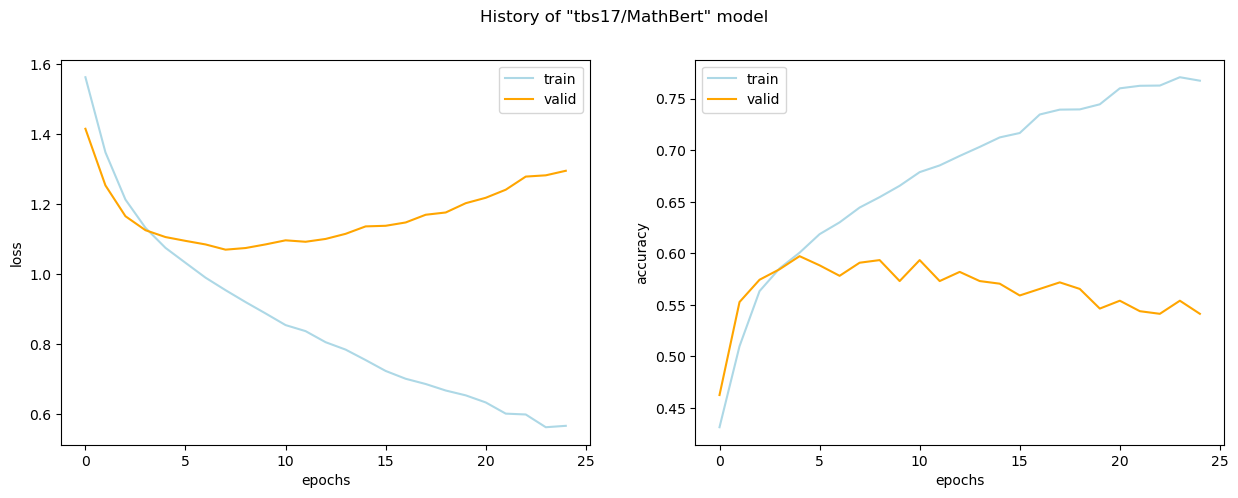

In [27]:
history_plot(mathbert_history_loss_unfrz, mathbert_history_acc_unfrz, MODEL_NAME)
MEAN_ACC_MODELS_HISTORY['accuracy'+MODEL_NAME] = np.mean(mathbert_history_acc_unfrz['valid'])

### Обучение кастомной модели на базе 'tbs17/MathBert' с замороженными весами

In [28]:
# Обучение кастомной модели на базе  'tbs17/MathBert' с замороженными весами.
mathbert_frz, mb_history_loss_frz, mb_history_acc_frz = train_transformer(transformer_model=model_mb
                                                                          ,n_epochs=50
                                                                          ,train_dataloader=train_loader_mb
                                                                          ,eval_dataloader=eval_loader_mb
                                                                          ,freeze_backbone=True
                                                                          ,device=device)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

EPOCH 1: 
**TRAIN loss: 1.9761201485083522 **TRAIN Accuracy: 0.18612483161203414 
**EVAL loss: 1.8986897480608238 **EVAL Accuracy: 0.21728081321473952 
 ----------------------------------------------------------------------------------------------------


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

EPOCH 2: 
**TRAIN loss: 1.8251775511704038 **TRAIN Accuracy: 0.2761562640323305 
**EVAL loss: 1.7660522930549853 **EVAL Accuracy: 0.3138500635324015 
 ----------------------------------------------------------------------------------------------------


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

EPOCH 3: 
**TRAIN loss: 1.728483127864031 **TRAIN Accuracy: 0.36012572968118545 
**EVAL loss: 1.6801816333423962 **EVAL Accuracy: 0.37229987293519695 
 ----------------------------------------------------------------------------------------------------


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

EPOCH 4: 
**TRAIN loss: 1.6553683674036388 **TRAIN Accuracy: 0.4106421194431971 
**EVAL loss: 1.626678067024308 **EVAL Accuracy: 0.4142312579415502 
 ----------------------------------------------------------------------------------------------------


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

EPOCH 5: 
**TRAIN loss: 1.6175758411380126 **TRAIN Accuracy: 0.4333183655141446 
**EVAL loss: 1.599335946217932 **EVAL Accuracy: 0.43964421855146124 
 ----------------------------------------------------------------------------------------------------


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

EPOCH 6: 
**TRAIN loss: 1.5969305373861797 **TRAIN Accuracy: 0.43780871127076787 
**EVAL loss: 1.577051994776485 **EVAL Accuracy: 0.4409148665819568 
 ----------------------------------------------------------------------------------------------------


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

EPOCH 7: 
**TRAIN loss: 1.5861150650140632 **TRAIN Accuracy: 0.44387067804220925 
**EVAL loss: 1.5654529592003485 **EVAL Accuracy: 0.44599745870393903 
 ----------------------------------------------------------------------------------------------------


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

EPOCH 8: 
**TRAIN loss: 1.576382261877846 **TRAIN Accuracy: 0.44454422990570275 
**EVAL loss: 1.5542218950059679 **EVAL Accuracy: 0.4485387547649301 
 ----------------------------------------------------------------------------------------------------


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

EPOCH 9: 
**TRAIN loss: 1.5686130062226327 **TRAIN Accuracy: 0.44634036820835205 
**EVAL loss: 1.5488686025744738 **EVAL Accuracy: 0.4498094027954257 
 ----------------------------------------------------------------------------------------------------


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

EPOCH 10: 
**TRAIN loss: 1.5573019210155719 **TRAIN Accuracy: 0.4526268522676246 
**EVAL loss: 1.5448301663302413 **EVAL Accuracy: 0.4536213468869123 
 ----------------------------------------------------------------------------------------------------


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

EPOCH 11: 
**TRAIN loss: 1.554394087483806 **TRAIN Accuracy: 0.44881005837449484 
**EVAL loss: 1.5336954888671335 **EVAL Accuracy: 0.4536213468869123 
 ----------------------------------------------------------------------------------------------------


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

EPOCH 12: 
**TRAIN loss: 1.5466998018671534 **TRAIN Accuracy: 0.4539739559946116 
**EVAL loss: 1.5233886880103988 **EVAL Accuracy: 0.45235069885641677 
 ----------------------------------------------------------------------------------------------------


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

EPOCH 13: 
**TRAIN loss: 1.5368448914592838 **TRAIN Accuracy: 0.44881005837449484 
**EVAL loss: 1.5156617712492895 **EVAL Accuracy: 0.4536213468869123 
 ----------------------------------------------------------------------------------------------------


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

EPOCH 14: 
**TRAIN loss: 1.5285787531124648 **TRAIN Accuracy: 0.45060619667714413 
**EVAL loss: 1.5068934824731615 **EVAL Accuracy: 0.45616264294790343 
 ----------------------------------------------------------------------------------------------------


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

EPOCH 15: 
**TRAIN loss: 1.5267152273526756 **TRAIN Accuracy: 0.4533004041311181 
**EVAL loss: 1.502425329251723 **EVAL Accuracy: 0.45616264294790343 
 ----------------------------------------------------------------------------------------------------


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

EPOCH 16: 
**TRAIN loss: 1.5199369021214038 **TRAIN Accuracy: 0.45038167938931295 
**EVAL loss: 1.4948766333888275 **EVAL Accuracy: 0.45743329097839897 
 ----------------------------------------------------------------------------------------------------


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

EPOCH 17: 
**TRAIN loss: 1.5116412109798856 **TRAIN Accuracy: 0.455994611585092 
**EVAL loss: 1.4886349427579628 **EVAL Accuracy: 0.4599745870393901 
 ----------------------------------------------------------------------------------------------------


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

EPOCH 18: 
**TRAIN loss: 1.50625717319468 **TRAIN Accuracy: 0.44993264481365064 
**EVAL loss: 1.4820830749742913 **EVAL Accuracy: 0.4599745870393901 
 ----------------------------------------------------------------------------------------------------


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

EPOCH 19: 
**TRAIN loss: 1.4984903504344298 **TRAIN Accuracy: 0.45352492141894923 
**EVAL loss: 1.4785067427037941 **EVAL Accuracy: 0.4625158831003812 
 ----------------------------------------------------------------------------------------------------


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

EPOCH 20: 
**TRAIN loss: 1.4951025604347175 **TRAIN Accuracy: 0.4515042658284688 
**EVAL loss: 1.4709348522051415 **EVAL Accuracy: 0.4599745870393901 
 ----------------------------------------------------------------------------------------------------


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

EPOCH 21: 
**TRAIN loss: 1.4896199216124832 **TRAIN Accuracy: 0.460035922766053 
**EVAL loss: 1.4676478565341295 **EVAL Accuracy: 0.4599745870393901 
 ----------------------------------------------------------------------------------------------------


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

EPOCH 22: 
**TRAIN loss: 1.4813921284931961 **TRAIN Accuracy: 0.4553210597215986 
**EVAL loss: 1.4605564312501387 **EVAL Accuracy: 0.4625158831003812 
 ----------------------------------------------------------------------------------------------------


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

EPOCH 23: 
**TRAIN loss: 1.4747312180030303 **TRAIN Accuracy: 0.4550965424337674 
**EVAL loss: 1.455780712643055 **EVAL Accuracy: 0.4599745870393901 
 ----------------------------------------------------------------------------------------------------


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

EPOCH 24: 
**TRAIN loss: 1.4665376155179888 **TRAIN Accuracy: 0.4577907498877414 
**EVAL loss: 1.4492415852016873 **EVAL Accuracy: 0.4599745870393901 
 ----------------------------------------------------------------------------------------------------


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

EPOCH 25: 
**TRAIN loss: 1.4739541449854452 **TRAIN Accuracy: 0.4577907498877414 
**EVAL loss: 1.4445558774350868 **EVAL Accuracy: 0.4599745870393901 
 ----------------------------------------------------------------------------------------------------


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

EPOCH 26: 
**TRAIN loss: 1.4572685764681907 **TRAIN Accuracy: 0.4636281993713516 
**EVAL loss: 1.436683298361422 **EVAL Accuracy: 0.46378653113087676 
 ----------------------------------------------------------------------------------------------------


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

EPOCH 27: 
**TRAIN loss: 1.454964444628753 **TRAIN Accuracy: 0.4593623709025595 
**EVAL loss: 1.4395194432952187 **EVAL Accuracy: 0.46378653113087676 
 ----------------------------------------------------------------------------------------------------


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

EPOCH 28: 
**TRAIN loss: 1.4551209610850153 **TRAIN Accuracy: 0.457341715312079 
**EVAL loss: 1.4277143315835432 **EVAL Accuracy: 0.46378653113087676 
 ----------------------------------------------------------------------------------------------------


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

EPOCH 29: 
**TRAIN loss: 1.4473413145670326 **TRAIN Accuracy: 0.46026044005388417 
**EVAL loss: 1.4271344644854767 **EVAL Accuracy: 0.46378653113087676 
 ----------------------------------------------------------------------------------------------------


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

EPOCH 30: 
**TRAIN loss: 1.4435428175874936 **TRAIN Accuracy: 0.46587337224966324 
**EVAL loss: 1.4186068020685754 **EVAL Accuracy: 0.46378653113087676 
 ----------------------------------------------------------------------------------------------------


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

EPOCH 31: 
**TRAIN loss: 1.4320544600486755 **TRAIN Accuracy: 0.46744499326448136 
**EVAL loss: 1.418938848707411 **EVAL Accuracy: 0.4650571791613723 
 ----------------------------------------------------------------------------------------------------


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

EPOCH 32: 
**TRAIN loss: 1.4340342317430776 **TRAIN Accuracy: 0.46609788953749437 
**EVAL loss: 1.4100074665714997 **EVAL Accuracy: 0.4650571791613723 
 ----------------------------------------------------------------------------------------------------


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

EPOCH 33: 
**TRAIN loss: 1.428664097008312 **TRAIN Accuracy: 0.46811854512797485 
**EVAL loss: 1.4076815337845774 **EVAL Accuracy: 0.4701397712833545 
 ----------------------------------------------------------------------------------------------------


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

EPOCH 34: 
**TRAIN loss: 1.4212457437241803 **TRAIN Accuracy: 0.47013920071845533 
**EVAL loss: 1.4077218451885263 **EVAL Accuracy: 0.4714104193138501 
 ----------------------------------------------------------------------------------------------------


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

EPOCH 35: 
**TRAIN loss: 1.4246500401513977 **TRAIN Accuracy: 0.4714863044454423 
**EVAL loss: 1.4025247265594174 **EVAL Accuracy: 0.47522236340533675 
 ----------------------------------------------------------------------------------------------------


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

EPOCH 36: 
**TRAIN loss: 1.4213109727828734 **TRAIN Accuracy: 0.46677144140098786 
**EVAL loss: 1.394740793440077 **EVAL Accuracy: 0.4726810673443456 
 ----------------------------------------------------------------------------------------------------


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

EPOCH 37: 
**TRAIN loss: 1.4132862080382618 **TRAIN Accuracy: 0.47238437359676694 
**EVAL loss: 1.3924666631101357 **EVAL Accuracy: 0.47522236340533675 
 ----------------------------------------------------------------------------------------------------


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

EPOCH 38: 
**TRAIN loss: 1.4072865627999802 **TRAIN Accuracy: 0.4762011674898967 
**EVAL loss: 1.3895579564450966 **EVAL Accuracy: 0.47395171537484115 
 ----------------------------------------------------------------------------------------------------


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

EPOCH 39: 
**TRAIN loss: 1.4043332111878206 **TRAIN Accuracy: 0.48069151324652 
**EVAL loss: 1.3873692949612935 **EVAL Accuracy: 0.4764930114358323 
 ----------------------------------------------------------------------------------------------------


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

EPOCH 40: 
**TRAIN loss: 1.4093515802455205 **TRAIN Accuracy: 0.47305792546026043 
**EVAL loss: 1.3852541934360156 **EVAL Accuracy: 0.47903430749682335 
 ----------------------------------------------------------------------------------------------------


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

EPOCH 41: 
**TRAIN loss: 1.3981115149340748 **TRAIN Accuracy: 0.48742703188145486 
**EVAL loss: 1.3749533084907917 **EVAL Accuracy: 0.4815756035578145 
 ----------------------------------------------------------------------------------------------------


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

EPOCH 42: 
**TRAIN loss: 1.3918277713133016 **TRAIN Accuracy: 0.4797934440951953 
**EVAL loss: 1.3765522536605295 **EVAL Accuracy: 0.48538754764930114 
 ----------------------------------------------------------------------------------------------------


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

EPOCH 43: 
**TRAIN loss: 1.389637254045001 **TRAIN Accuracy: 0.48697799730579255 
**EVAL loss: 1.3726471102598943 **EVAL Accuracy: 0.4891994917407878 
 ----------------------------------------------------------------------------------------------------


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

EPOCH 44: 
**TRAIN loss: 1.387658695379893 **TRAIN Accuracy: 0.48832510103277954 
**EVAL loss: 1.3663289998516892 **EVAL Accuracy: 0.4891994917407878 
 ----------------------------------------------------------------------------------------------------


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

EPOCH 45: 
**TRAIN loss: 1.3935465699455645 **TRAIN Accuracy: 0.4822631342613381 
**EVAL loss: 1.3650408820672468 **EVAL Accuracy: 0.49047013977128334 
 ----------------------------------------------------------------------------------------------------


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

EPOCH 46: 
**TRAIN loss: 1.3823936363702178 **TRAIN Accuracy: 0.4860799281544679 
**EVAL loss: 1.364235652215553 **EVAL Accuracy: 0.49809402795425667 
 ----------------------------------------------------------------------------------------------------


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

EPOCH 47: 
**TRAIN loss: 1.3825919243597216 **TRAIN Accuracy: 0.4860799281544679 
**EVAL loss: 1.3638031609130628 **EVAL Accuracy: 0.49809402795425667 
 ----------------------------------------------------------------------------------------------------


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

EPOCH 48: 
**TRAIN loss: 1.380516381887552 **TRAIN Accuracy: 0.48720251459362374 
**EVAL loss: 1.358238848772916 **EVAL Accuracy: 0.49809402795425667 
 ----------------------------------------------------------------------------------------------------


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

EPOCH 49: 
**TRAIN loss: 1.376581495808017 **TRAIN Accuracy: 0.48652896273013024 
**EVAL loss: 1.3576999228410047 **EVAL Accuracy: 0.5069885641677255 
 ----------------------------------------------------------------------------------------------------


  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

EPOCH 50: 
**TRAIN loss: 1.3664610576031455 **TRAIN Accuracy: 0.48765154916928605 
**EVAL loss: 1.3543852904830316 **EVAL Accuracy: 0.5082592121982211 
 ----------------------------------------------------------------------------------------------------


Лучшая accuracy на валидации: 50.83


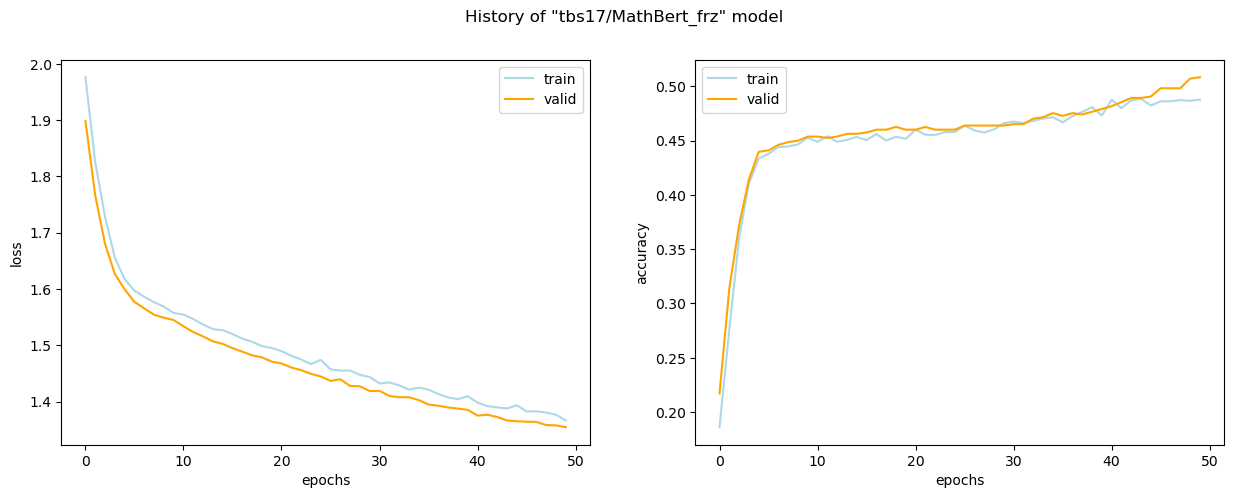

In [29]:
history_plot(mb_history_loss_frz, mb_history_acc_frz, MODEL_NAME_frz)
MEAN_ACC_MODELS_HISTORY['accuracy'+MODEL_NAME_frz] = np.mean(mb_history_acc_frz['valid'])

### Задание 6 (1 балл)

Напишите функцию для отрисовки карт внимания первого слоя для моделей из задания

In [30]:
eval_data[:3]

,problem_text,topic
2861,There's a table of 4x4 cells in some cells wit...,6
3064,Do these pairs exist different natural numbers...,0
3096,"In a passenger train of 17 wagons, how many wa...",2


In [31]:
# Тестовые датасеты.
test_dataset_rt = MyDataset(dataframe=eval_data[:3], tokenizer=tokenizer_rt)
test_dataset_mb = MyDataset(dataframe=eval_data[:3], tokenizer=tokenizer_mb)

# Тестовые даталоадеры.
test_loader_rt = DataLoader(test_dataset_rt, batch_size=1, shuffle=True)
test_loader_mb = DataLoader(test_dataset_mb, batch_size=1, shuffle=True)

In [32]:
def draw_first_layer_attention_maps(eval_loader, model, tokenizer, device=device):
    # Переводим модель в режим для оценки предсказаний
    model.eval()
    # Без расчёта производных.
    with torch.no_grad():
        # Получим данные из даталоадера.
        input_data, attention_mask, labels = next(iter(eval_loader))
        input_data, attention_mask, labels = input_data.to(device), attention_mask.to(device), labels.to(device)

        # Получим токены (слова) текста, который передаём на вход модели.
        tokens = tokenizer.convert_ids_to_tokens(input_data[0])
        # Удалим все '[PAD]' токены.
        tokens = ([t for t in tokens if t != '[PAD]'])
        print(f"Текст: {tokens}")
        # Кол-во токенов (слов) в первом предложении батча даталоадера.
        lenght = len(tokens)

        # Формируем вход для модели.
        inputs = {"input_ids": input_data, "attention_mask": attention_mask}

        # Получить значения attentions из модели.
        outputs = model(inputs)
        # Получить предсказания модели.
        pred = outputs['logits'].argmax(axis=-1)
        # Получить значения attentions из модели.
        attentions = outputs['attentions'][0]

        print(f"Предсказание: {pred.item()} - {ind2label[pred.item()]}")
        print(f"Правильный ответ: {labels.item()} - {ind2label[labels.item()]}")

        # Кол-во голов attention слоя.
        num_heads = attentions.size(1)
        
        # Отрисовать графики для всех голов.
        fig, axs = plt.subplots(4, 3, figsize=(lenght, lenght))

        for i in range(4):
            for j in range(3):
                n = (i+1)*(j+1)
                attention = attentions[0, n-1,:lenght,:lenght].cpu().detach().numpy()

                ax = axs[i, j]
                im = ax.imshow(attention, cmap='coolwarm')
                
                #sns.heatmap(attention, annot=False, square=True, cmap='coolwarm',xticklabels=tokens, yticklabels=tokens)
                
                ax.set_title(f'Head {n}')
                
                ax.set_xticks(range(len(tokens)))  # Устанавливаем числовые индексы
                ax.set_xticklabels(tokens, rotation=90)  # Добавляем подписи токенов
                ax.set_yticks(range(len(tokens)))  
                ax.set_yticklabels(tokens)  
    
        plt.tight_layout()
        plt.show()                

### Задание 7 (1 балл)

Проведите инференс для всех моделей **ДО ДООБУЧЕНИЯ** на 2-3 текстах из датасета. Посмотрите на головы Attention первого слоя в каждой модели на выбранных текстах (отрисуйте их отдельно).

Попробуйте их проинтерпретировать. Какие связи улавливают карты внимания? (если в модели много голов Attention, то проинтерпретируйте наиболее интересные)

**Получившееся карты внимания можно разделить на 2 группы: диагональные и вертикальные.**

**Диагональные в основе своей концентрируют внимание токенов на самих себя и лишь частично обращают внимание на прочие токены, то есть на выявление семантических связей токенов друг с другом.**

**Вертикальные же больше концентрируют внимание на прочие токены, а не на самих себя, то есть на выявление семантических связей токенов друг с другом.**

### Модель 'cointegrated/rubert-tiny2' ДО ДООБУЧЕНИЯ

Текст: ['[CLS]', 'pairs', 'exist', 'different', 'natural', 'numbers', 'n', 'p', 'q', 'n', 'p', 'q', '[SEP]']
Предсказание: 4 - geometry
Правильный ответ: 0 - number_theory


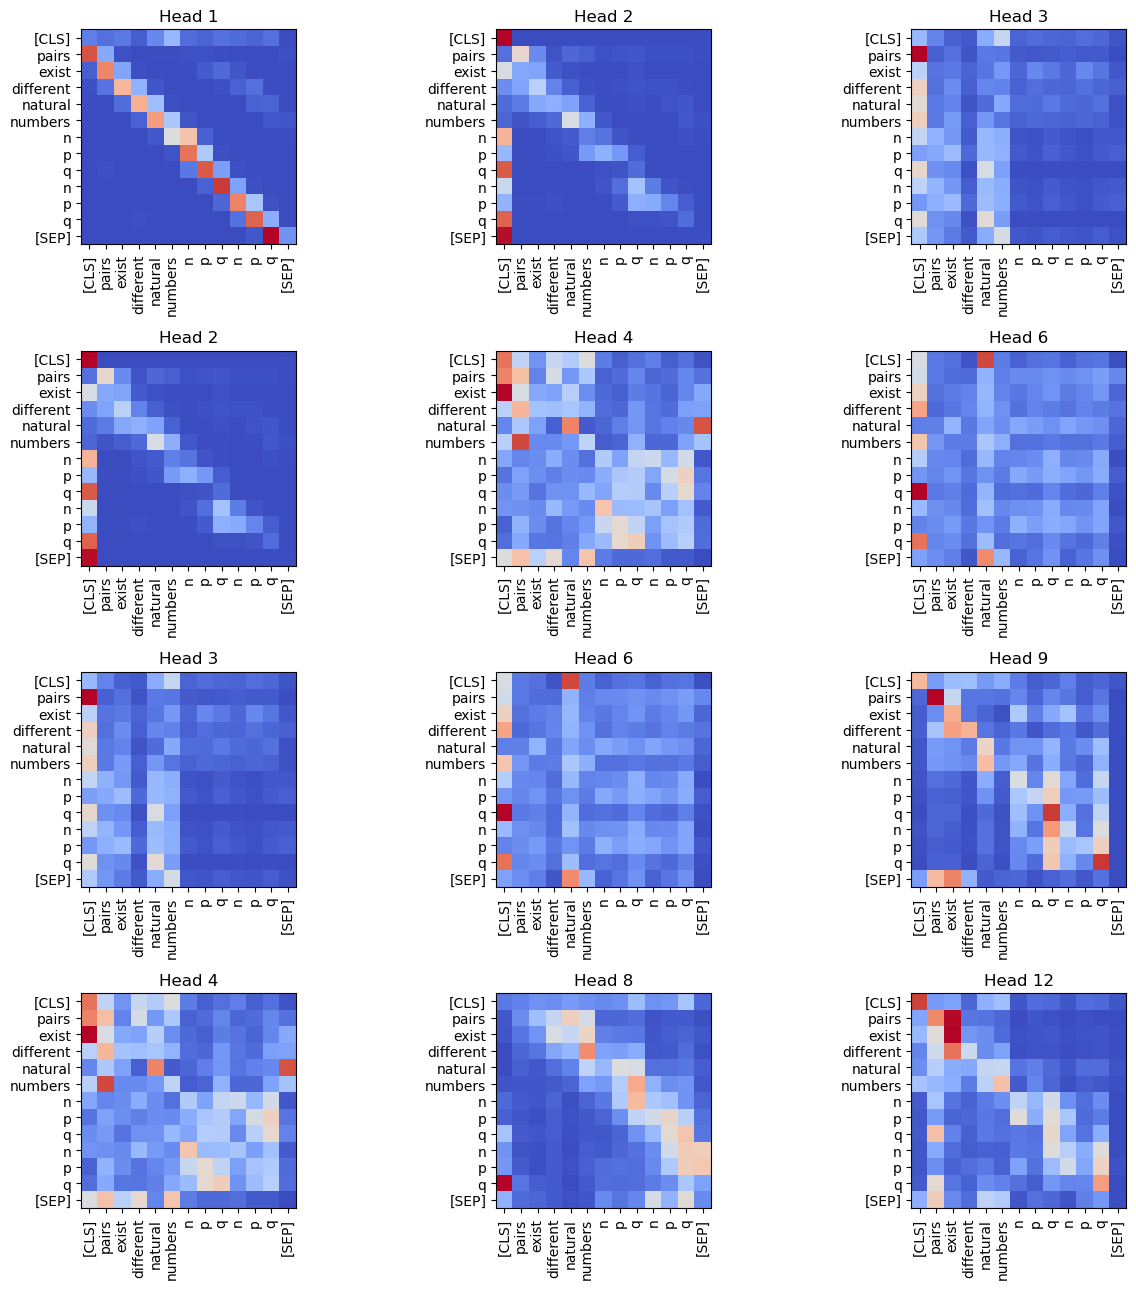

In [46]:
draw_first_layer_attention_maps(test_loader_rt, model_rt, tokenizer_rt, device=device)

### Модель 'tbs17/MathBert' ДО ДООБУЧЕНИЯ

Текст: ['[CLS]', 'pairs', 'exist', 'different', 'natural', 'numbers', 'n', 'p', 'q', 'n', 'p', 'q', '[SEP]']
Предсказание: 4 - geometry
Правильный ответ: 0 - number_theory


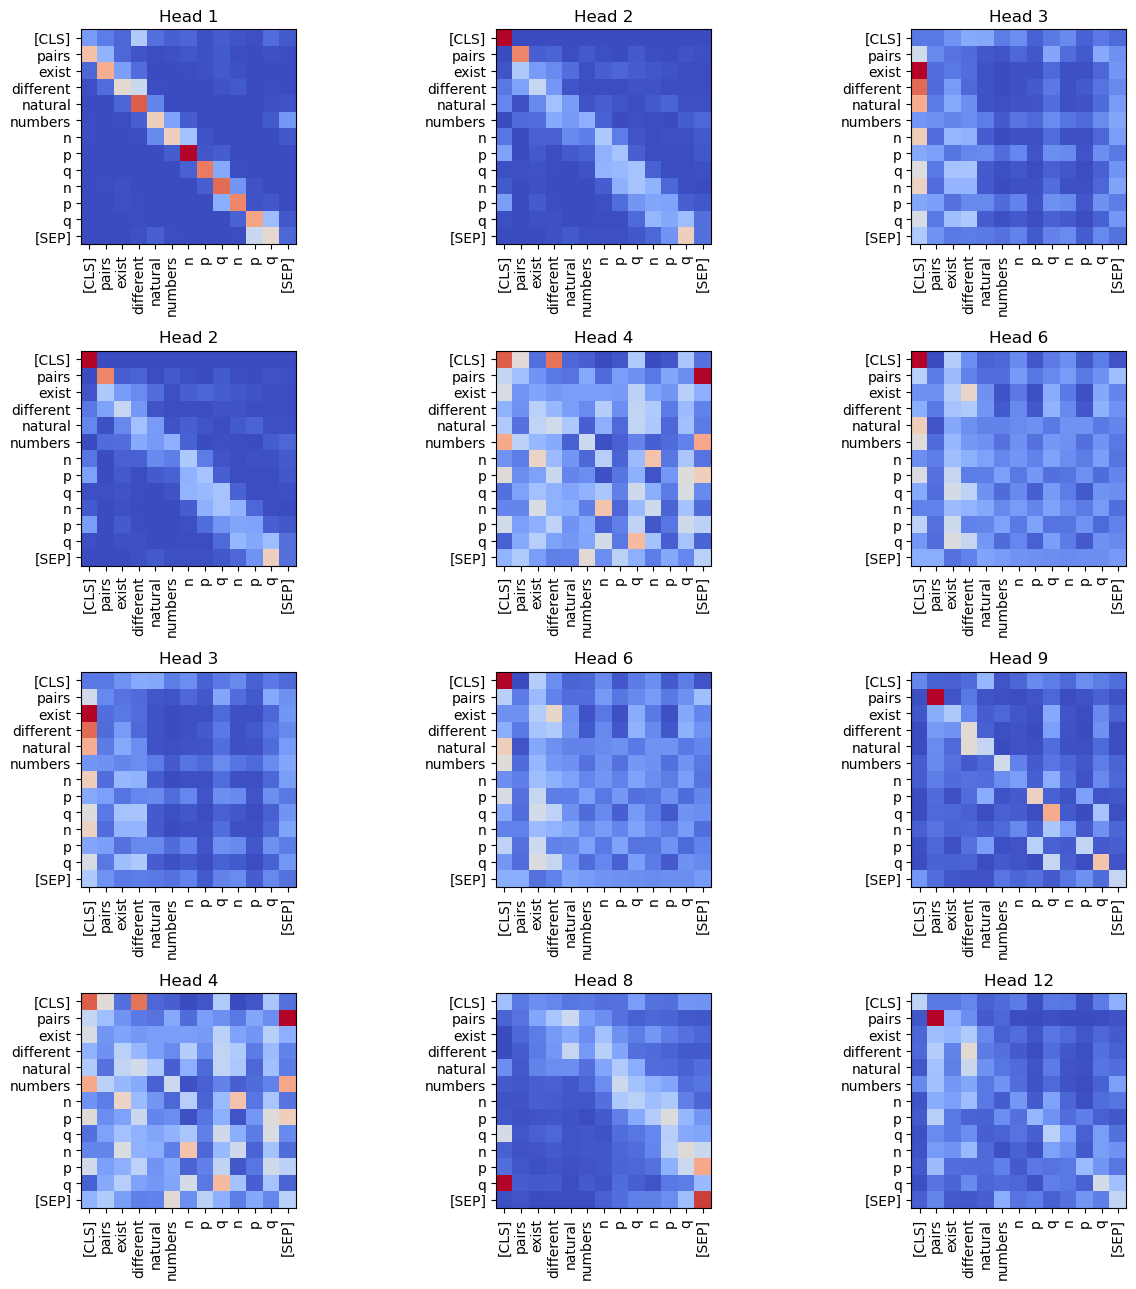

In [45]:
draw_first_layer_attention_maps(test_loader_mb, model_mb, tokenizer_mb, device=device)

### Задание 8 (1 балл)

Сделайте то же самое для дообученных моделей. Изменились ли карты внимания и связи, которые они улавливают? Почему?

**Да, карты внимания изменились для моделей, которые обучались без заморозки весов, что логично.**

### Модель 'cointegrated/rubert-tiny2' дообученная с замороженными весами

Текст: ['[CLS]', 'pairs', 'exist', 'different', 'natural', 'numbers', 'n', 'p', 'q', 'n', 'p', 'q', '[SEP]']
Предсказание: 0 - number_theory
Правильный ответ: 0 - number_theory


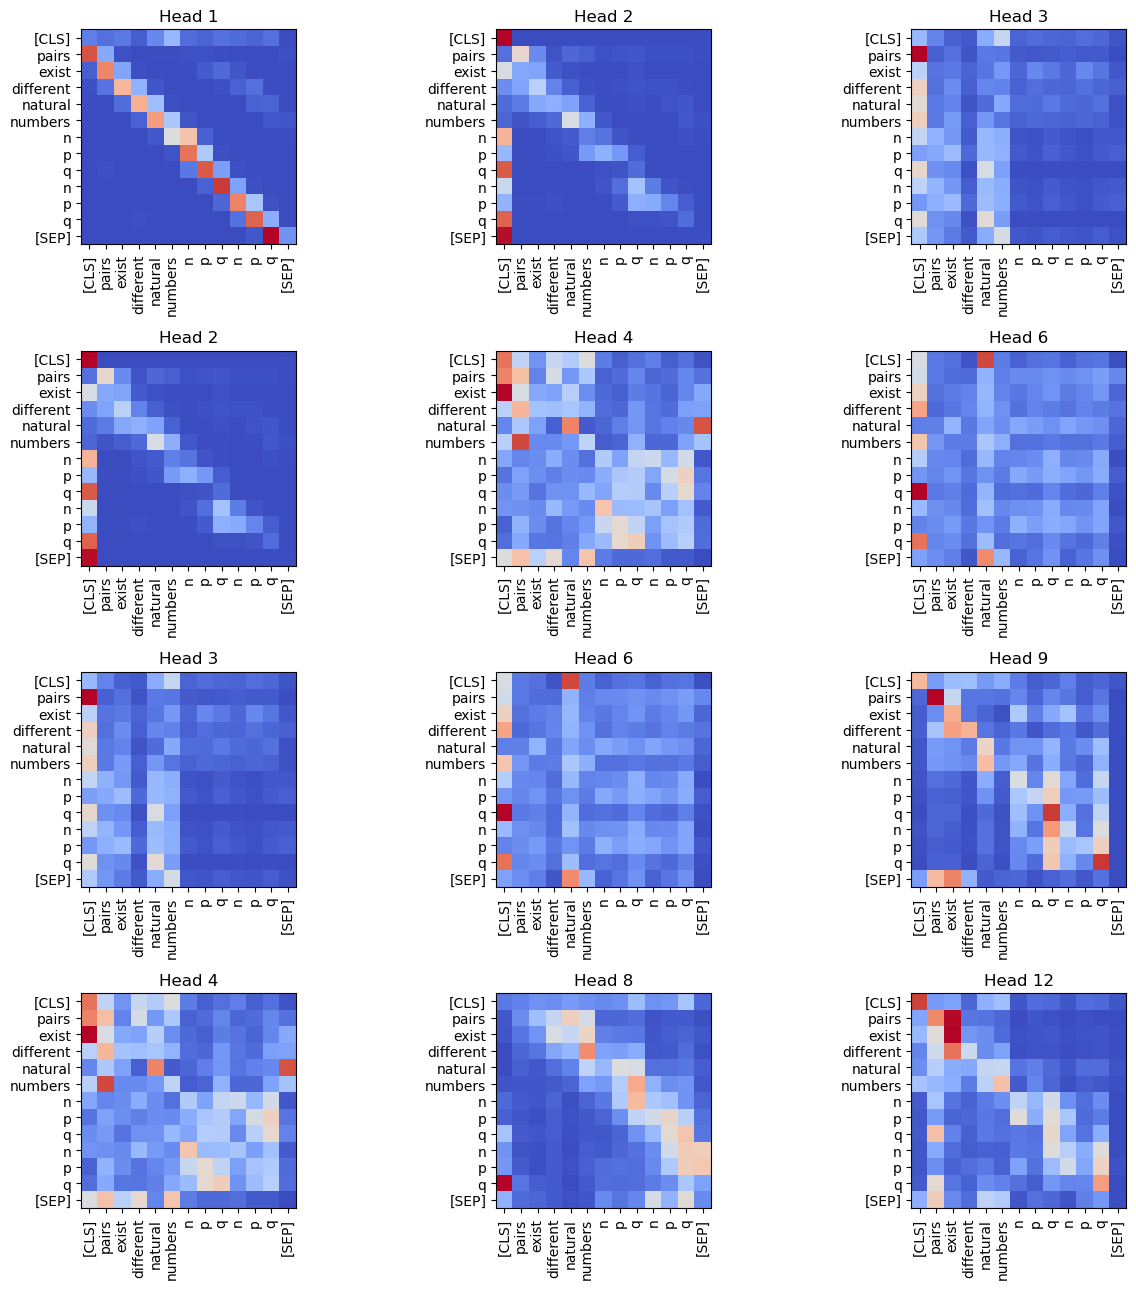

In [42]:
draw_first_layer_attention_maps(test_loader_rt, rubert_tiny_frz, tokenizer_rt, device=device)

### Модель 'cointegrated/rubert-tiny2' дообученная без замороженных весов

Текст: ['[CLS]', 'pairs', 'exist', 'different', 'natural', 'numbers', 'n', 'p', 'q', 'n', 'p', 'q', '[SEP]']
Предсказание: 0 - number_theory
Правильный ответ: 0 - number_theory


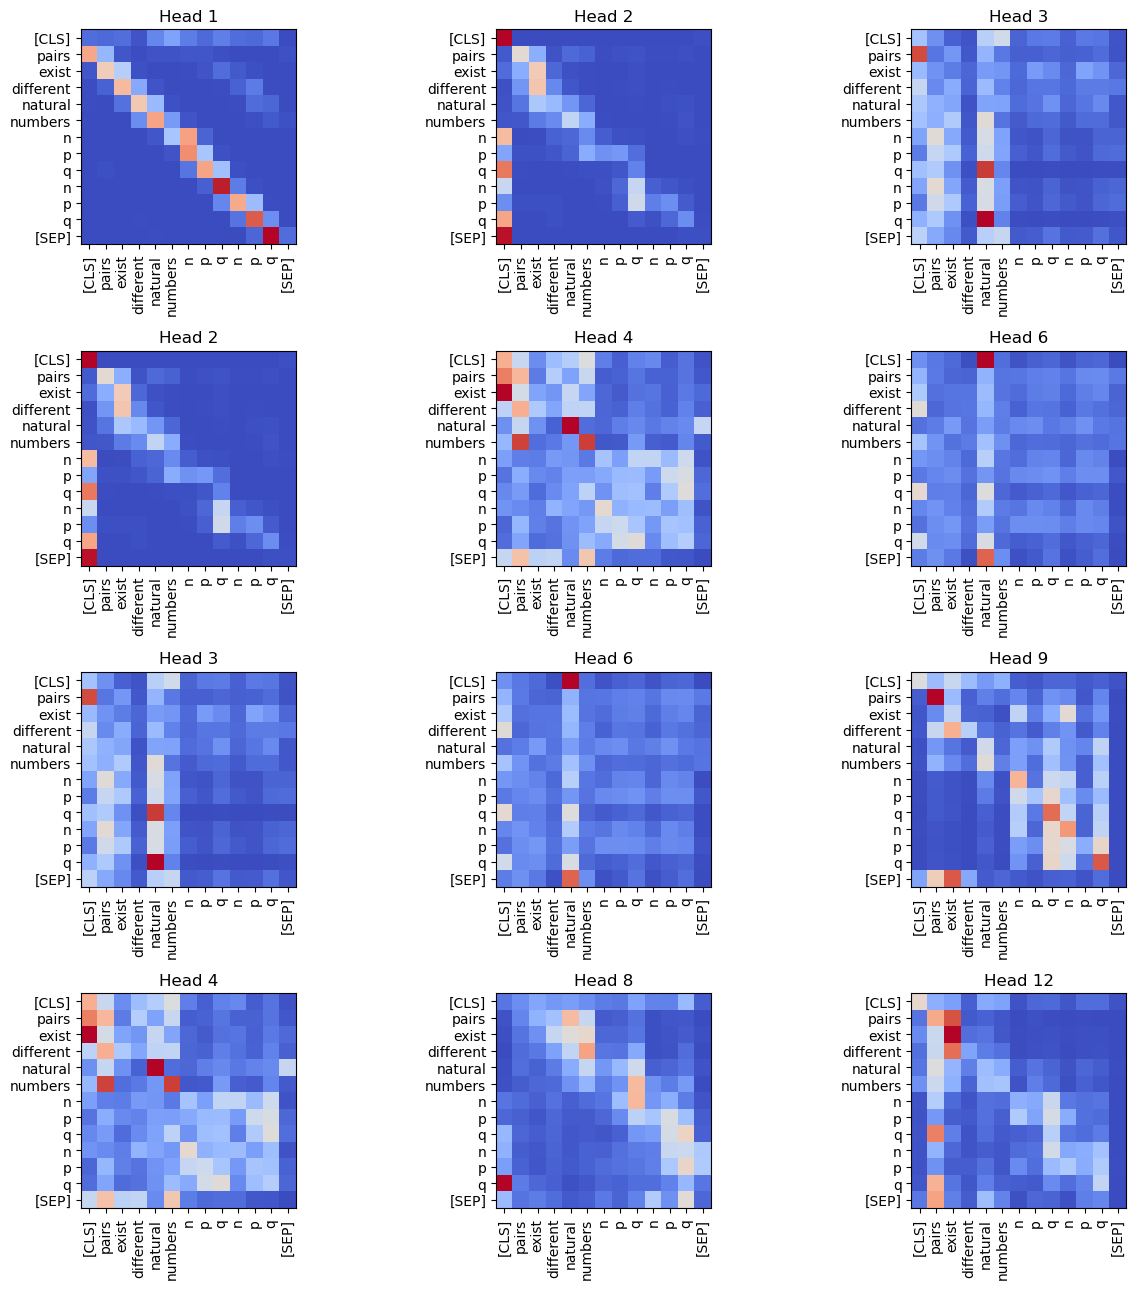

In [36]:
draw_first_layer_attention_maps(test_loader_rt, rubert_tiny_unfrz, tokenizer_rt, device=device)

### Модель 'tbs17/MathBert' дообученная с замороженными весами

Текст: ['[CLS]', 'pairs', 'exist', 'different', 'natural', 'numbers', 'n', 'p', 'q', 'n', 'p', 'q', '[SEP]']
Предсказание: 0 - number_theory
Правильный ответ: 0 - number_theory


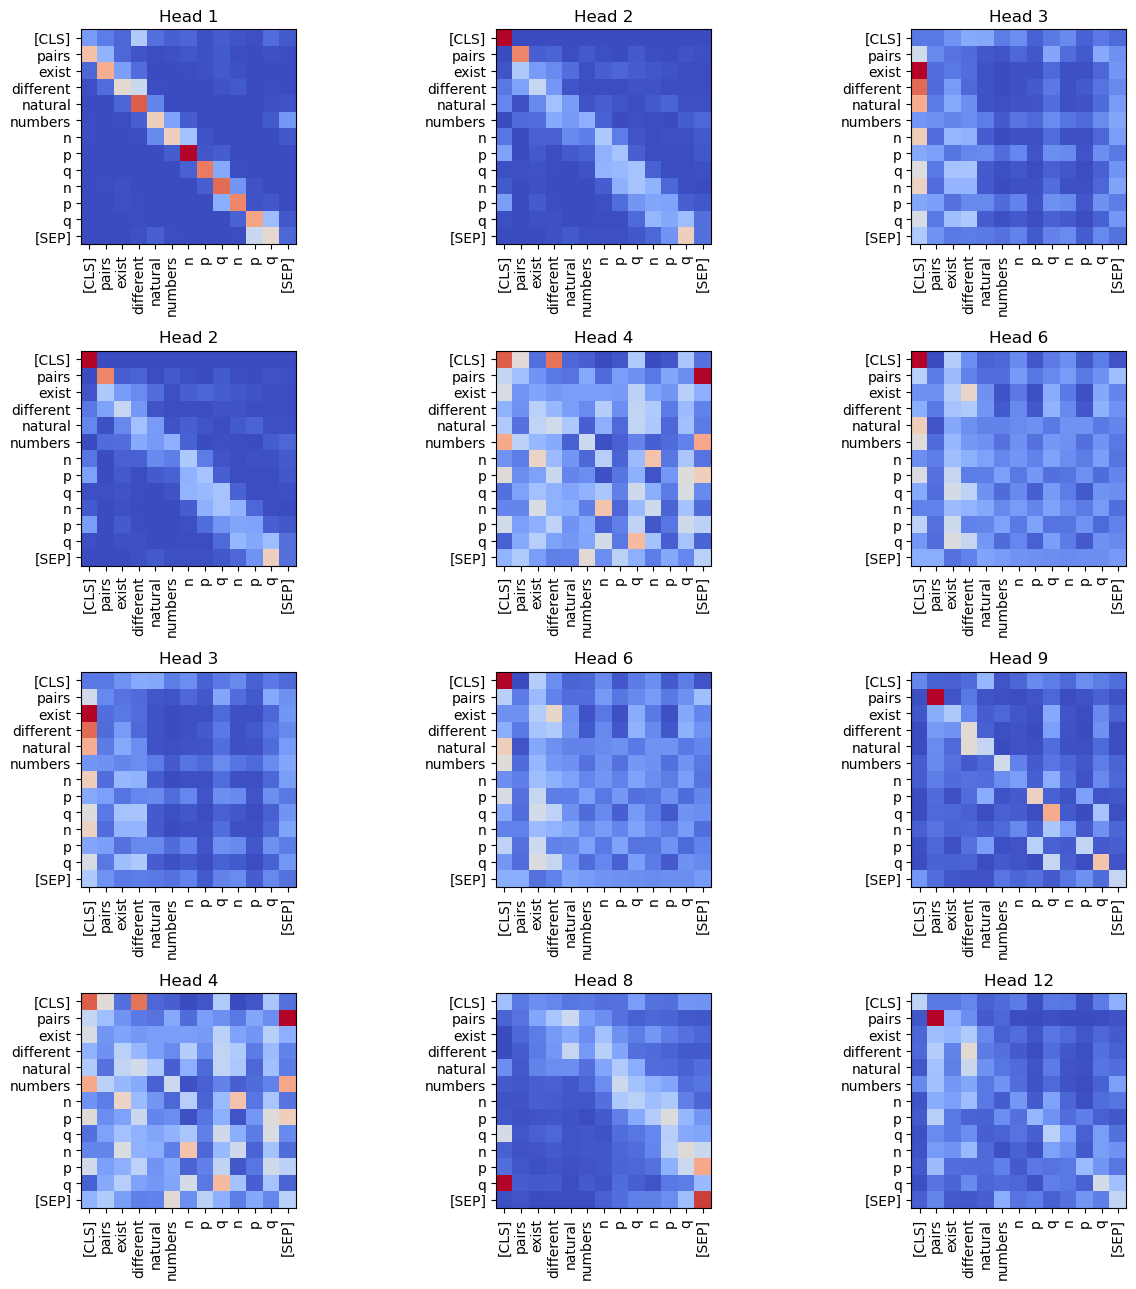

In [37]:
draw_first_layer_attention_maps(test_loader_mb, mathbert_frz, tokenizer_mb, device=device)

### Модель 'tbs17/MathBert' дообученная без замороженных весов

Текст: ['[CLS]', 'pairs', 'exist', 'different', 'natural', 'numbers', 'n', 'p', 'q', 'n', 'p', 'q', '[SEP]']
Предсказание: 0 - number_theory
Правильный ответ: 0 - number_theory


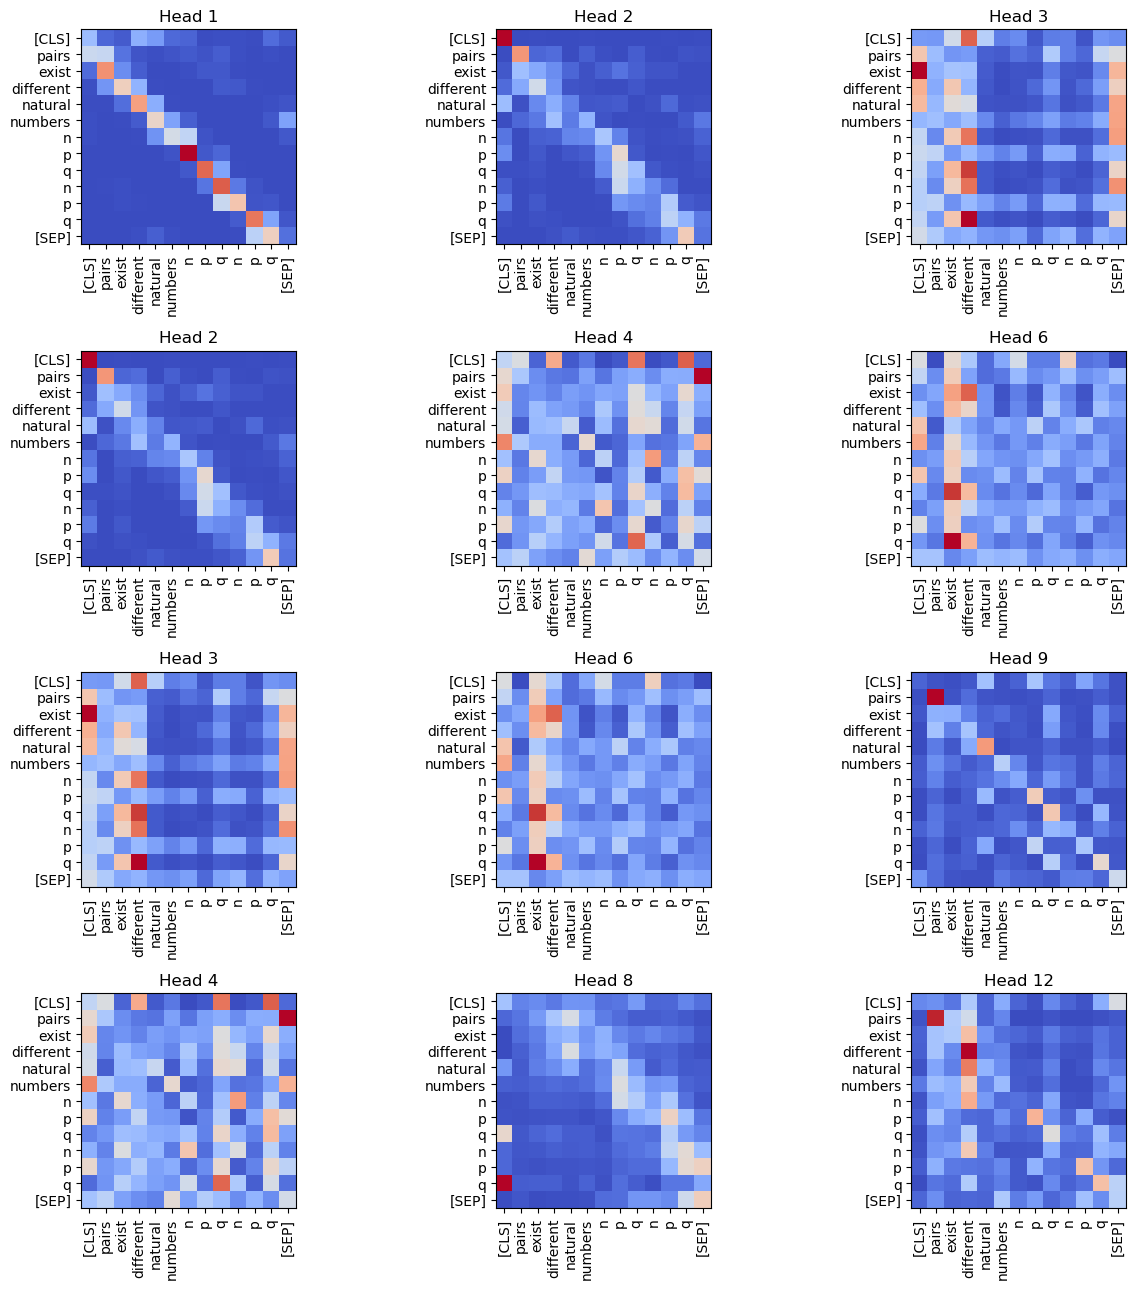

In [38]:
draw_first_layer_attention_maps(test_loader_mb, mathbert_unfrz, tokenizer_mb, device=device)